# deepBreaks applications
## Predicting the subtype of the HIV-1 virus based on its V3 amino-acid sequence   
PLACEHOLDER FOR DESCRIPTION
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1868395/
<p style="text-align:center;">
<figure>
  <img src="../img/HIV/v3.png" alt="V3" style="width: 400px;">
    <figcaption>Image from: <a size=10 href=https://doi.org/10.1371/journal.pcbi.0030058>Sander, Oliver, et al. "Structural descriptors of gp120 V3 loop for the prediction of HIV-1 coreceptor usage." PLoS computational biology 3.3 (2007): e58.</a> 
        </figcaption>
</figure>
</p>

In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/HIV/hiv_V3_B_C_nu_clean.fasta'
meta_data = '/Users/mbagh/Documents/RahLab/deepBreaks_data/HIV/results_V3_B_C_meta.csv'
# name of the phenotype
mt = 'Subtype'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)
metaData = prp.read_data(meta_data, is_main=False)
positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading fasta file
Done
Shape of data is:  (35424, 105)
CPU times: user 1.66 s, sys: 46.1 ms, total: 1.71 s
Wall time: 1.72 s


In [6]:
df.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p96,p97,p98,p99,p100,p101,p102,p103,p104,p105
A04321,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB001137,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB002829,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB002844,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T
AB002872,T,G,T,A,C,A,A,G,A,C,...,A,G,C,A,C,A,T,T,G,T


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [7]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


,Subtype
A04321,B
AB001137,B
AB002829,B
AB002844,B
AB002872,B


In [8]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [9]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (35424, 105)
Shape of data after missing/constant care:  (35424, 102)
CPU times: user 3.66 s, sys: 8.59 ms, total: 3.67 s
Wall time: 3.67 s


In [10]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (35424, 102)
Shape of data after imbalanced care:  (35424, 53)
CPU times: user 764 ms, sys: 3.65 ms, total: 768 ms
Wall time: 764 ms


In [11]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  53
number of columns of main data after:  52
CPU times: user 430 ms, sys: 5.76 ms, total: 436 ms
Wall time: 443 ms


In [12]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: user 180 ms, sys: 3.36 ms, total: 184 ms
Wall time: 180 ms


In [13]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(61, 61)
CPU times: user 111 ms, sys: 4.61 ms, total: 116 ms
Wall time: 115 ms


In [14]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


,p3_T,p4_GTC,p5_T,p6_GCT,p9_G,p12_T,p13_G,p14_G,p18_T,p21_T,...,p80_T,p85_G,p87_T,p93_G,p94_C,p95_GTC,p96_GTC,p100_T,p102_T,p105_T
p3_T,0.000000,0.994836,0.978291,0.988584,0.950248,0.994785,0.991591,0.940320,0.968597,0.983978,...,0.986415,0.978965,0.962255,0.978099,0.981797,0.988075,0.913849,0.999770,0.998590,0.979017
p4_GTC,0.994836,0.000000,0.812690,0.977173,0.985319,0.983528,0.996283,0.994662,0.909079,0.985347,...,0.982227,0.969628,0.940175,0.996279,0.990255,0.992837,0.990310,0.987890,0.973086,0.996826
p5_T,0.978291,0.812690,0.000000,0.893766,0.978740,0.932844,0.922649,0.953974,0.919990,0.993921,...,0.995318,0.982782,0.944010,0.985913,0.938612,0.990870,0.998522,0.956685,0.975373,0.988795
p6_GCT,0.988584,0.977173,0.893766,0.000000,0.981483,0.915772,0.963336,0.977852,0.859278,0.985808,...,0.986722,0.989725,0.960654,0.981441,0.996562,0.992888,0.982986,0.987706,0.961702,0.996669
p9_G,0.950248,0.985319,0.978740,0.981483,0.000000,0.979819,0.957705,0.892184,0.938584,0.974640,...,0.981923,0.996448,0.968594,0.970328,0.997639,0.960278,0.946598,0.977923,0.977728,0.941986


In [15]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.3,
                       needs_pivot=False)

finding colinear groups
CPU times: user 79.5 ms, sys: 44.1 ms, total: 124 ms
Wall time: 429 ms


In [16]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


,feature,group
8,p18_T,g0
20,p38_G,g0
21,p39_G,g0
22,p39_T,g0
31,p52_C,g0


Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [17]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: user 39.5 ms, sys: 4.95 ms, total: 44.4 ms
Wall time: 41.3 ms


In [18]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (35424, 61)
Shape of data after collinearity care:  (35424, 55)


In [19]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [20]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

,Description,Value
0,session_id,123
1,Target,Subtype
2,Target Type,Binary
3,Label Encoded,"B: 0, C: 1"
4,Original Data,"(35424, 56)"
5,Missing Values,False
6,Numeric Features,55
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


CPU times: user 17.8 s, sys: 3.3 s, total: 21.1 s
Wall time: 33 s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

Light Gradient Boosting MachineDone
Light Gradient Boosting Machine  Done
Extreme Gradient BoostingDone
Extreme Gradient Boosting  Done
Logistic RegressionDone
Logistic Regression  Done


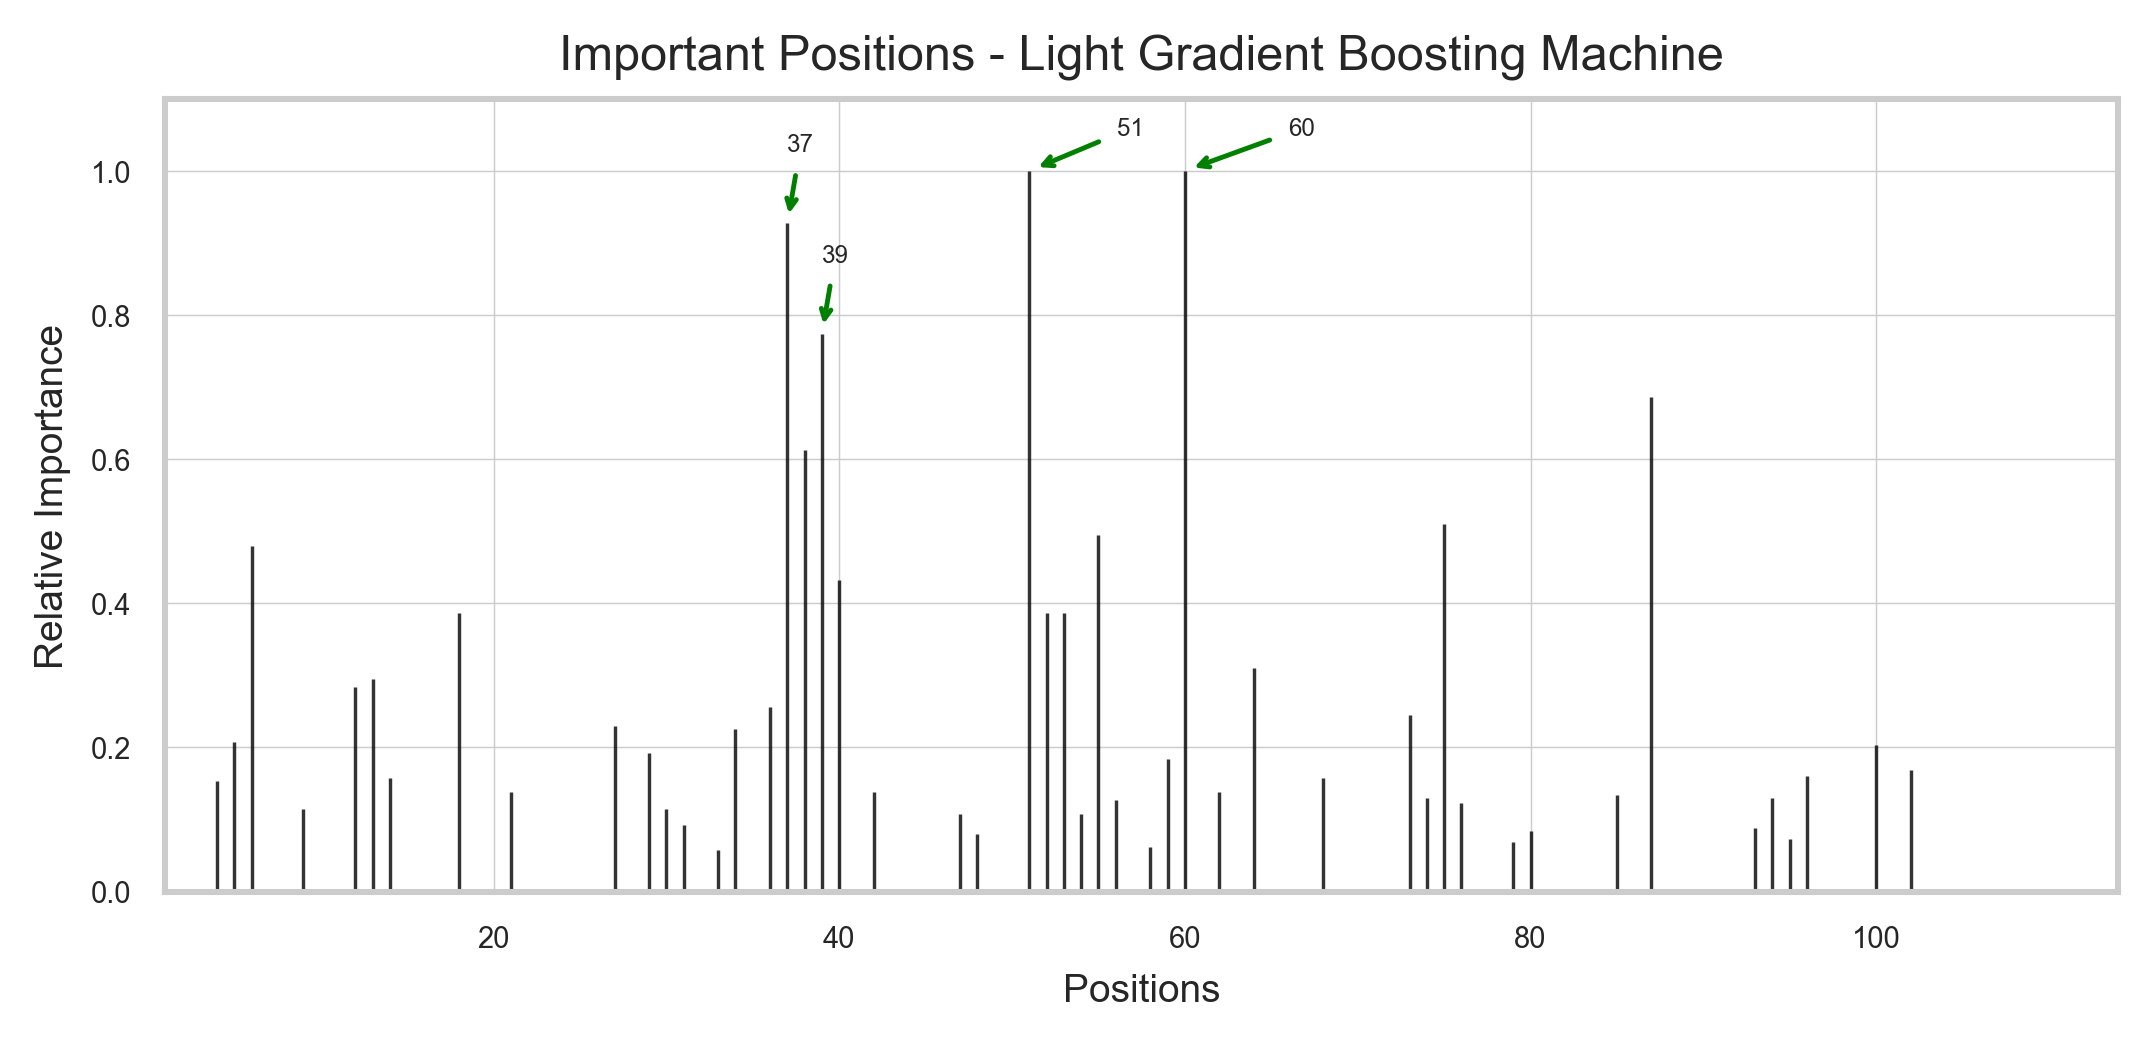

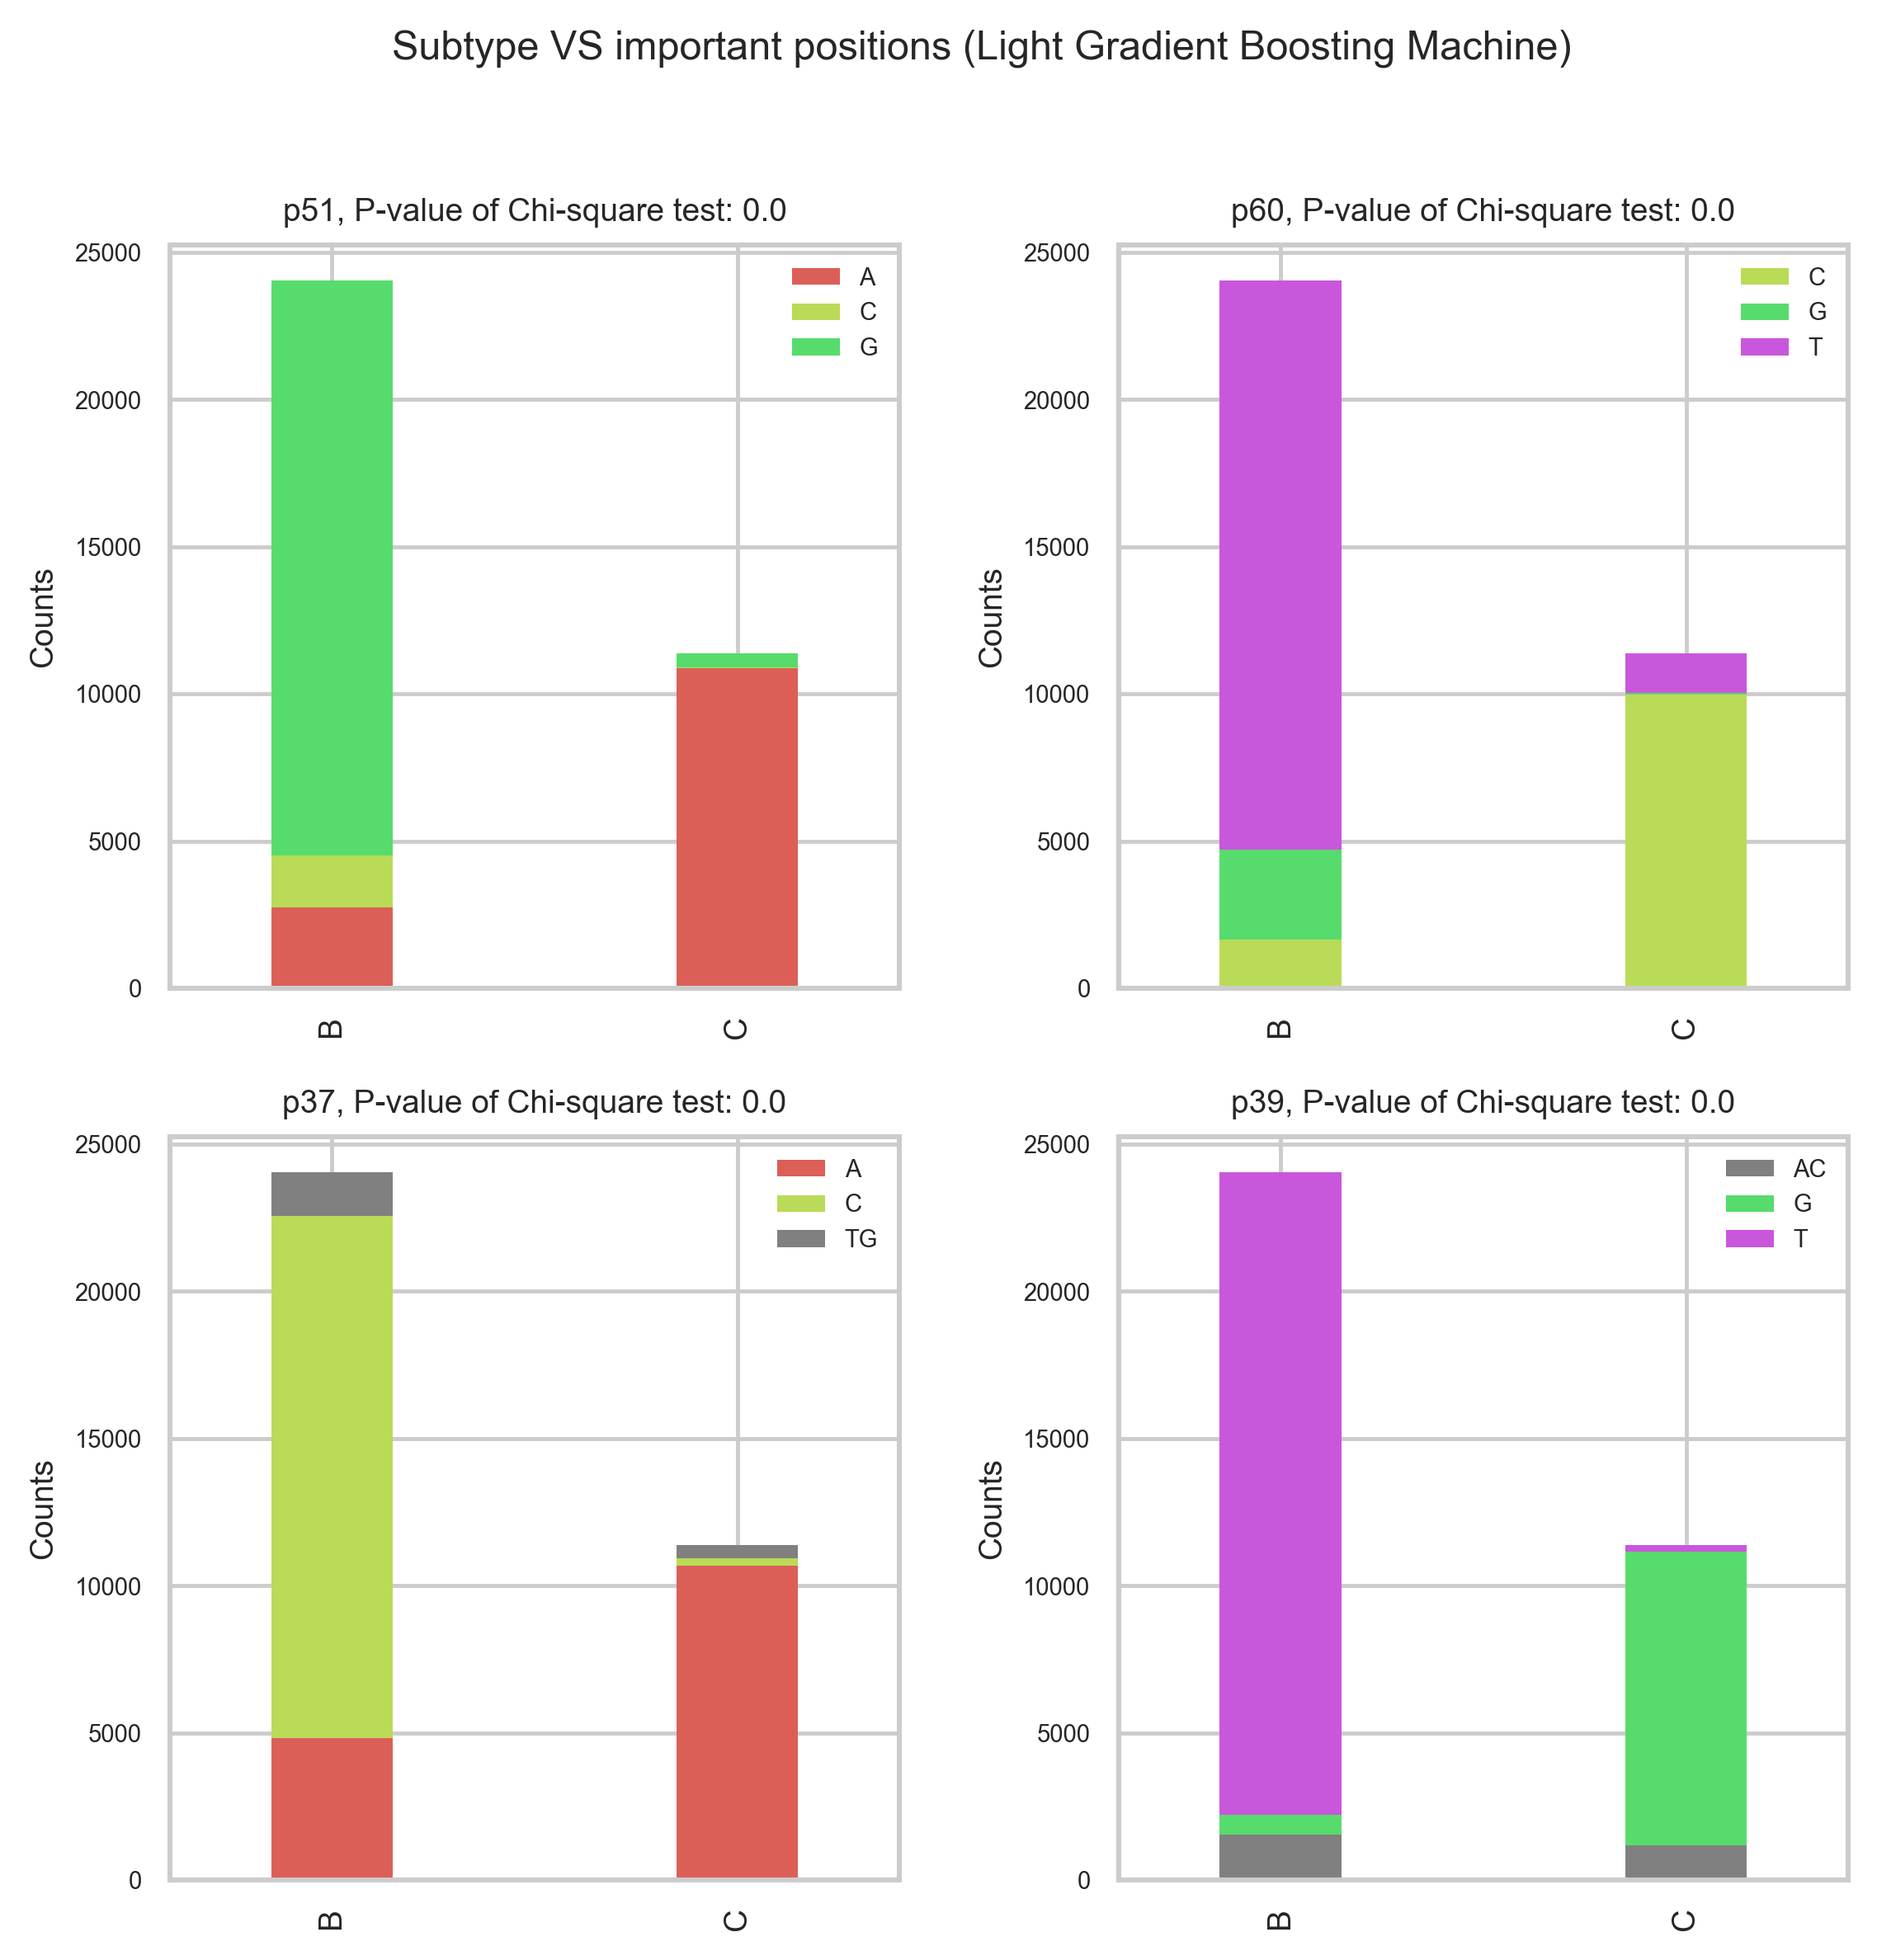

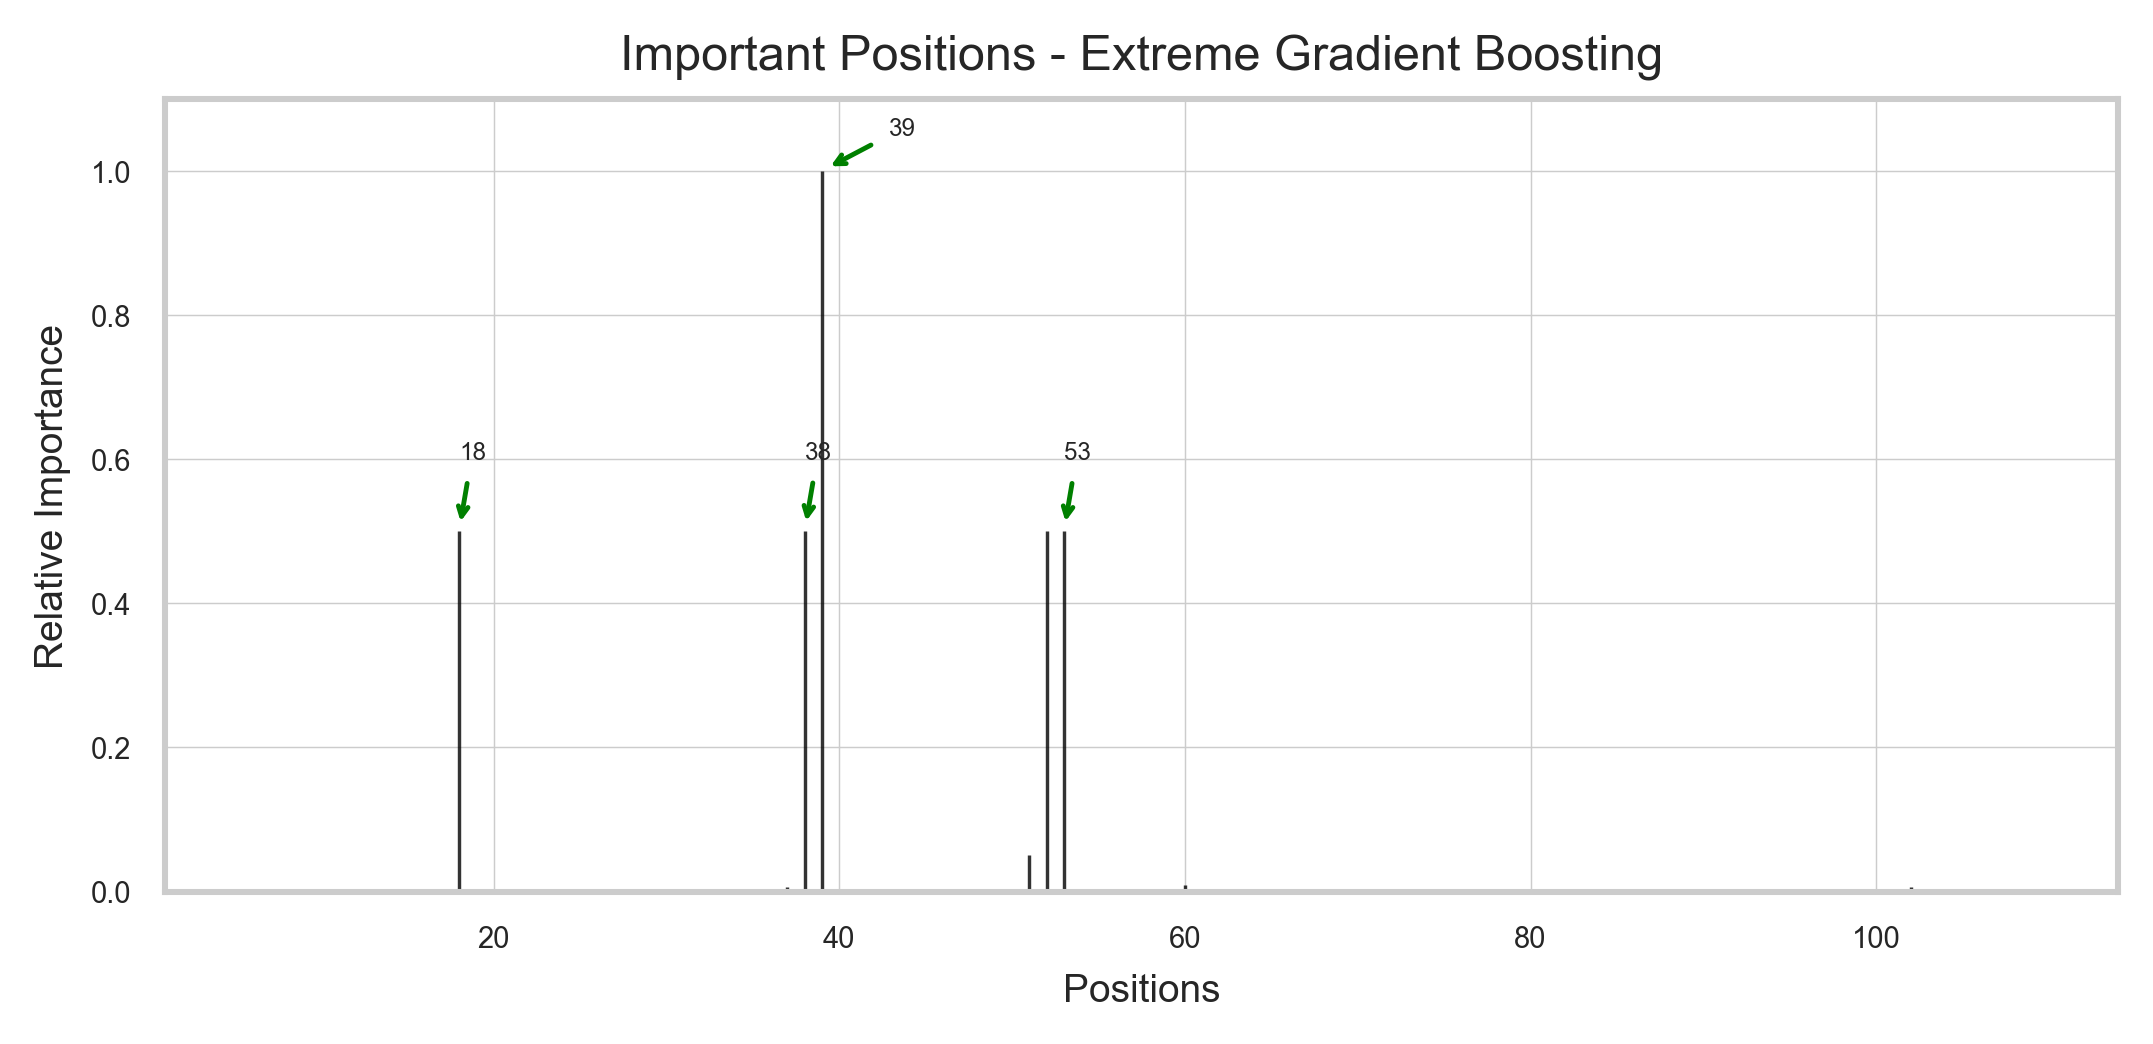

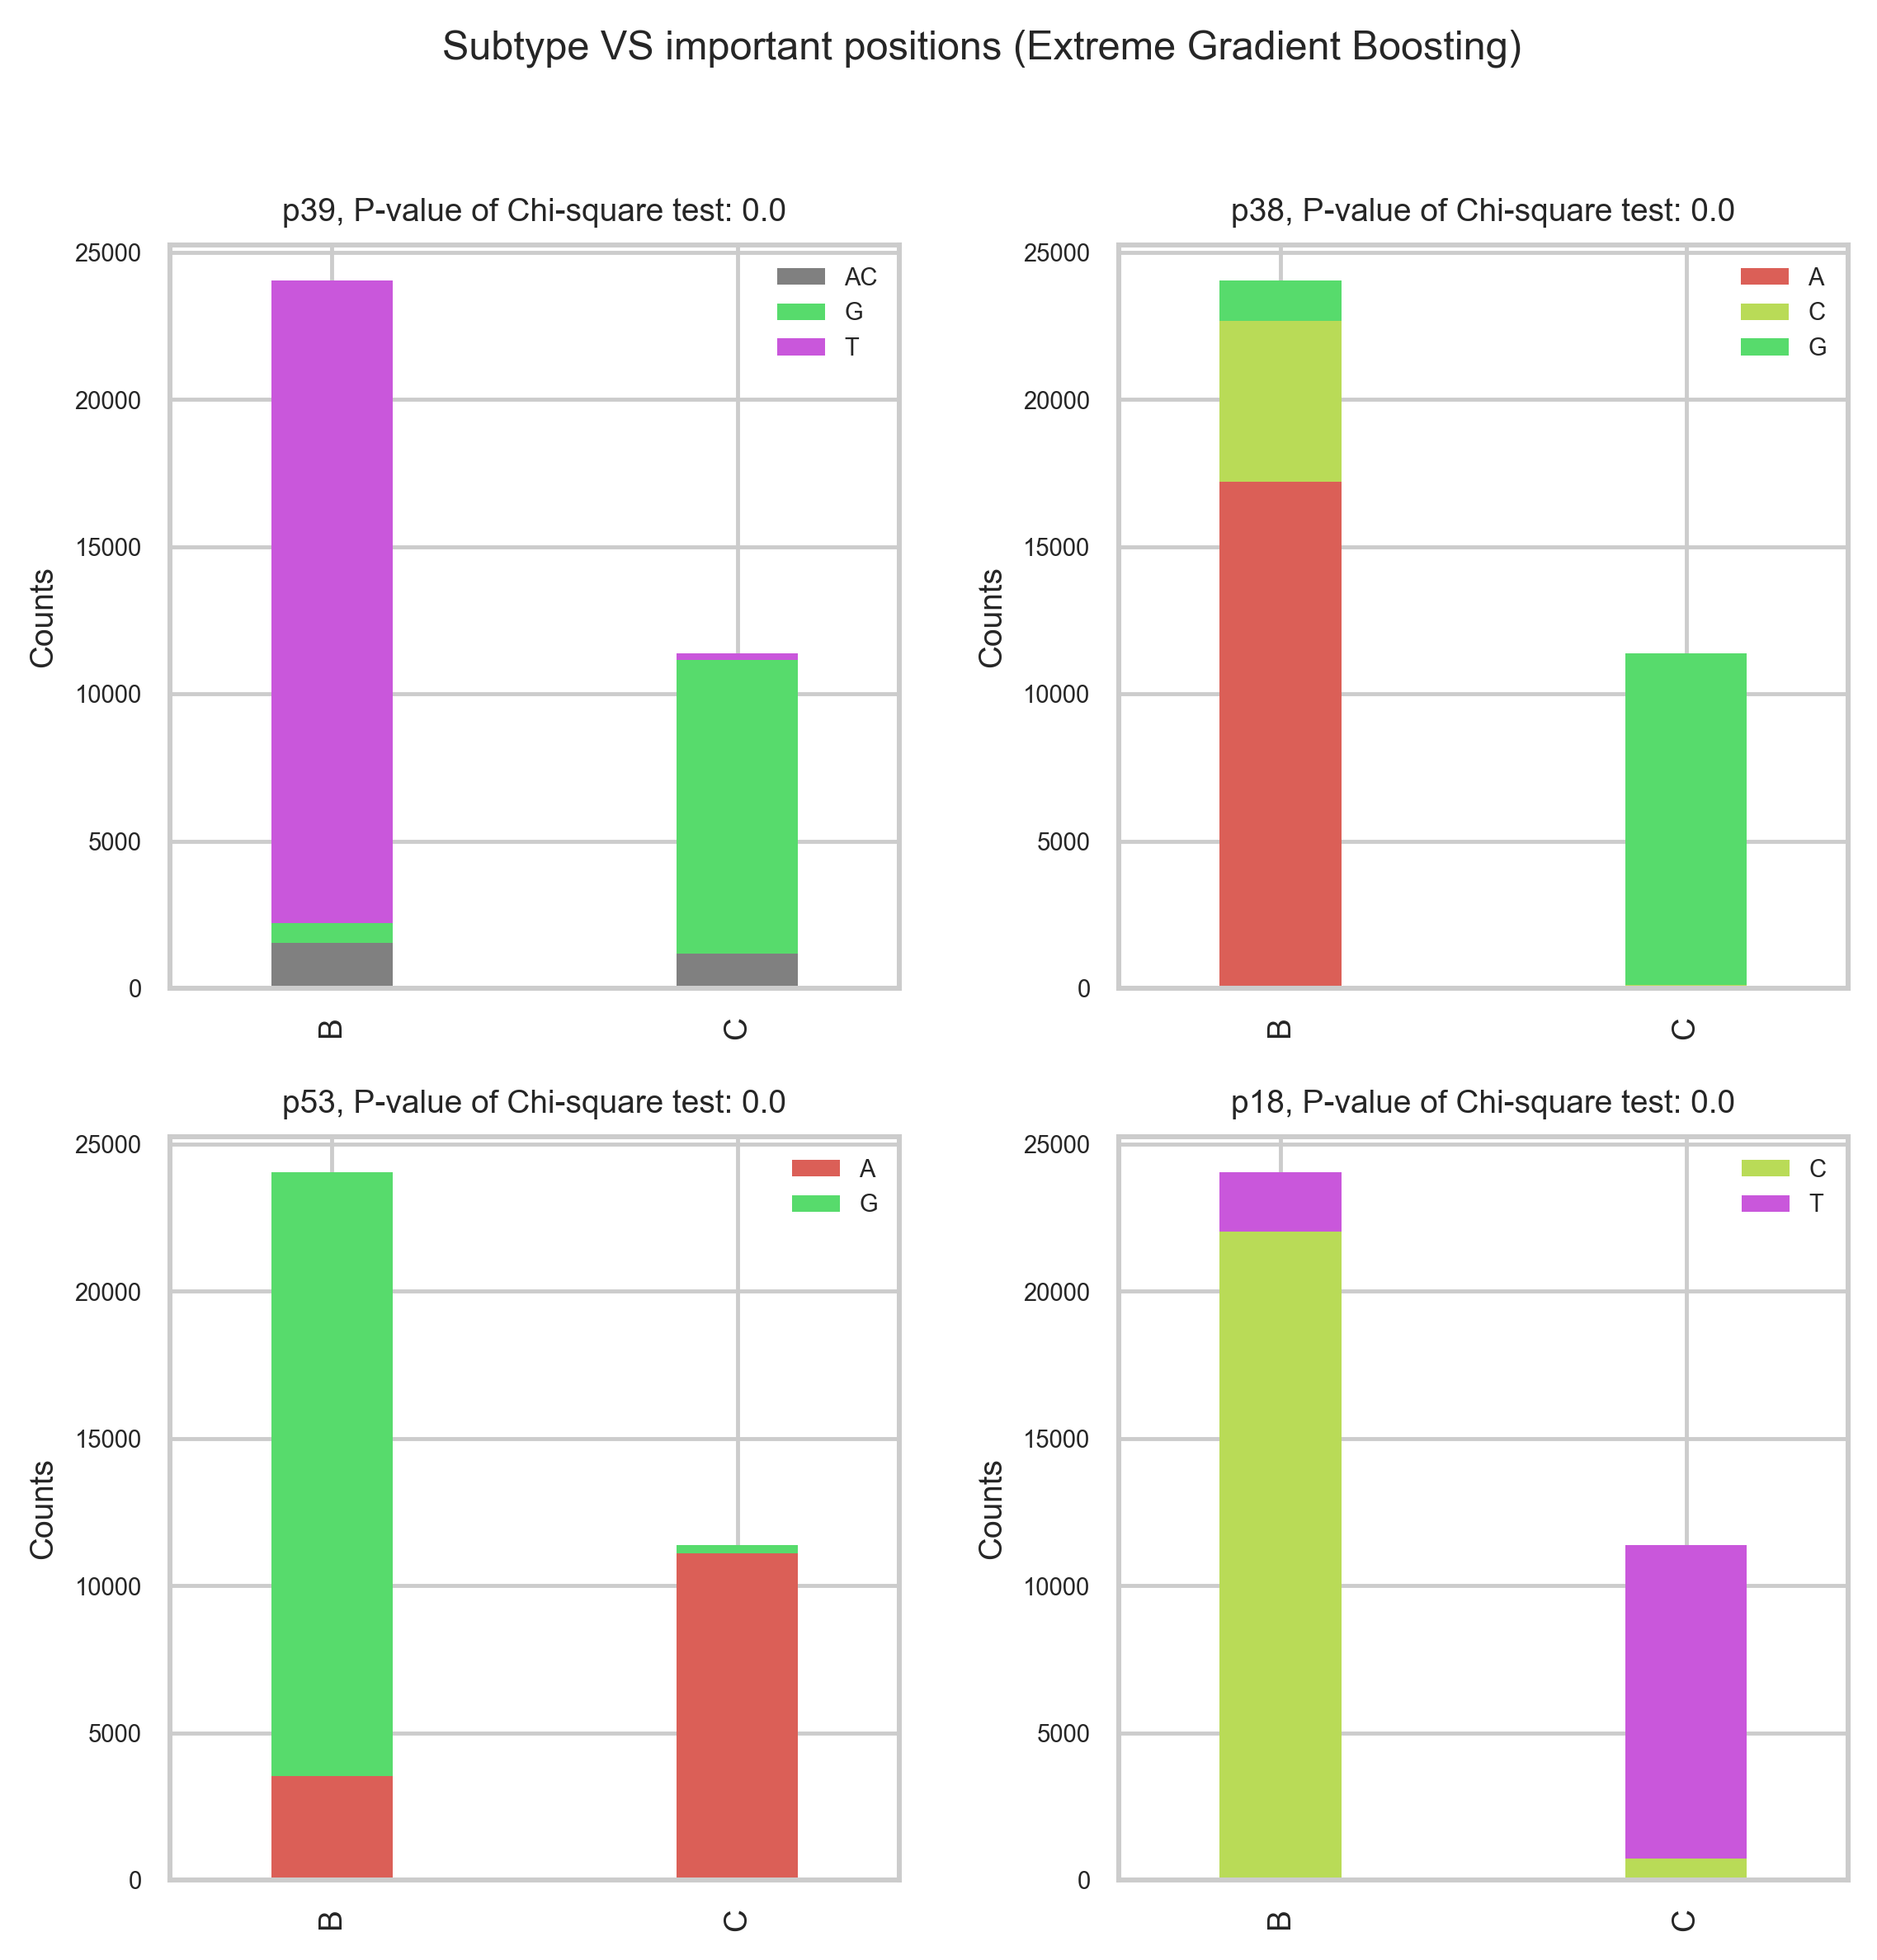

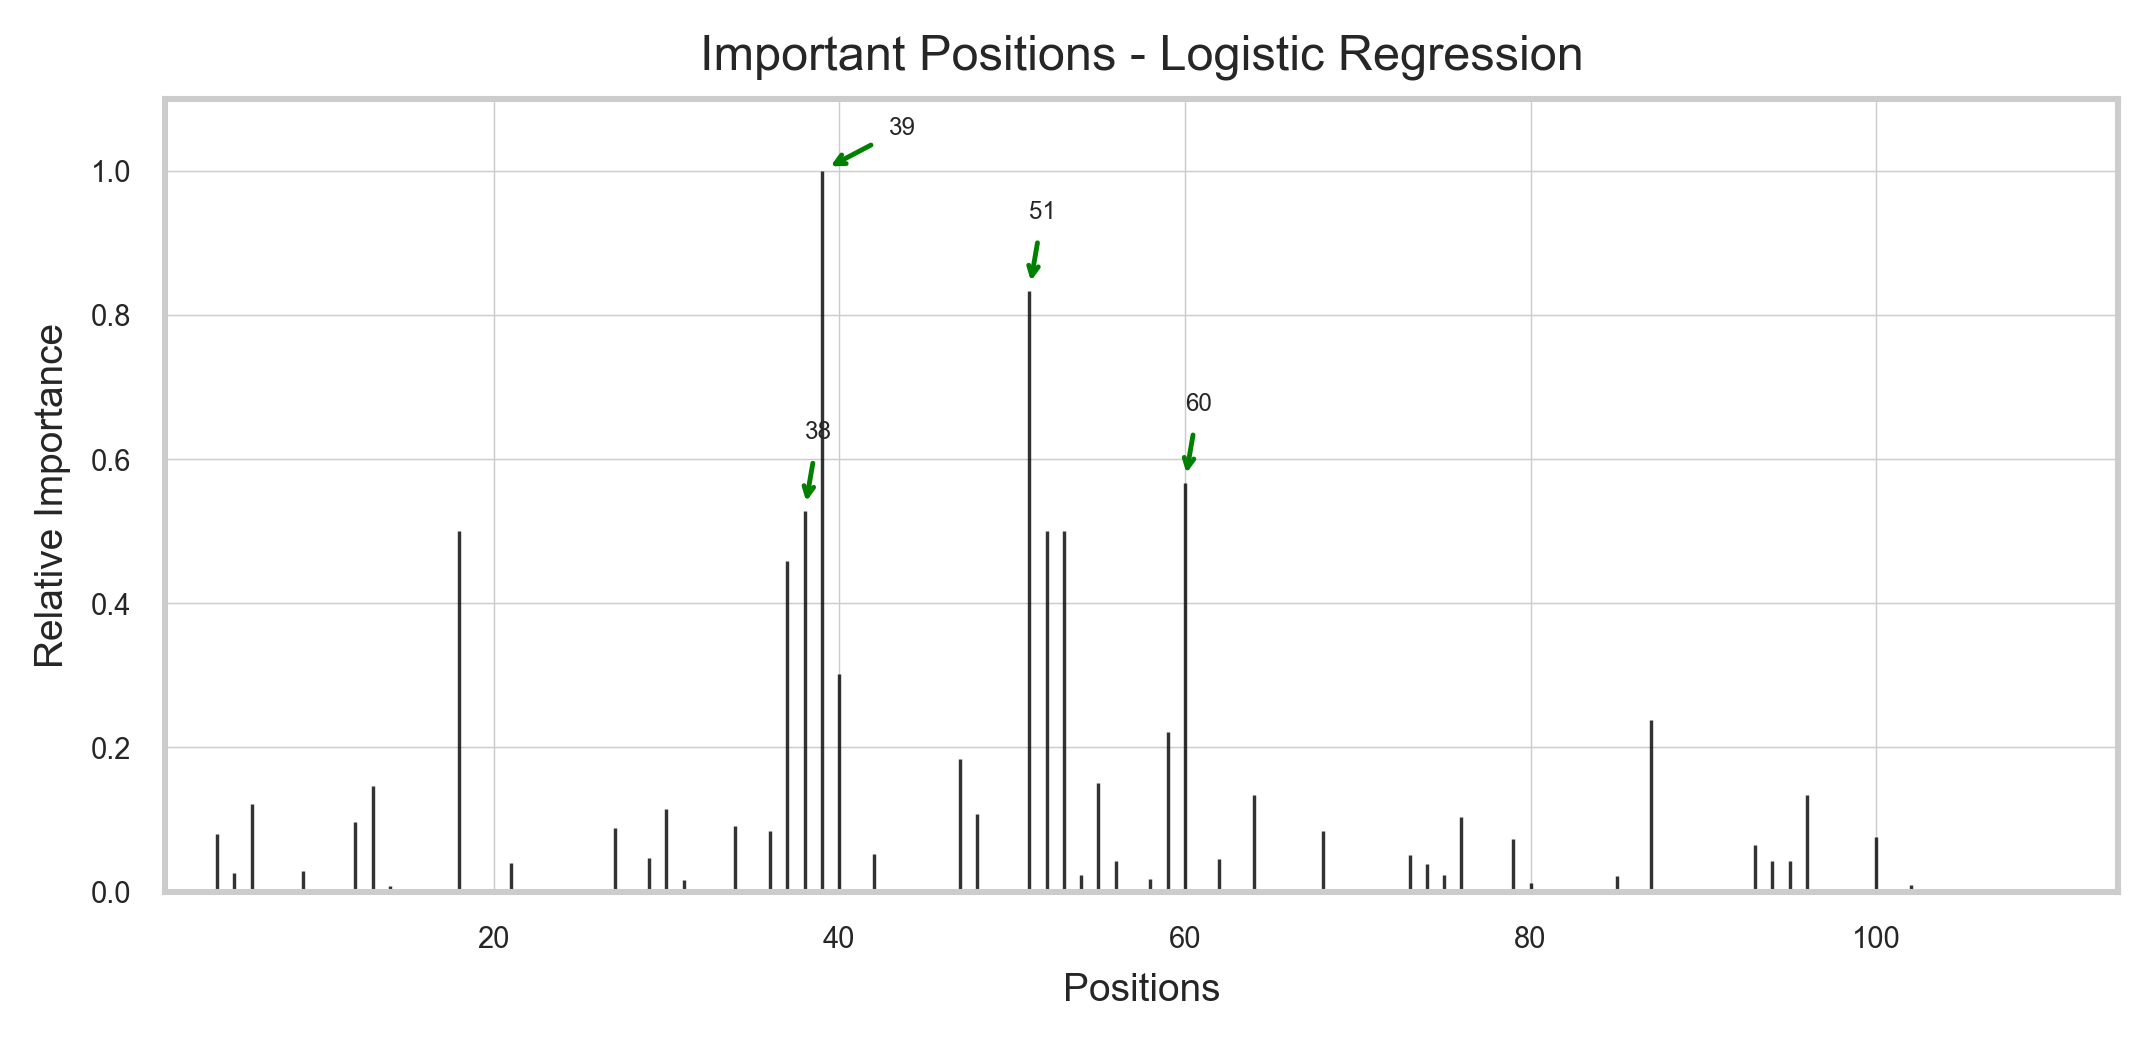

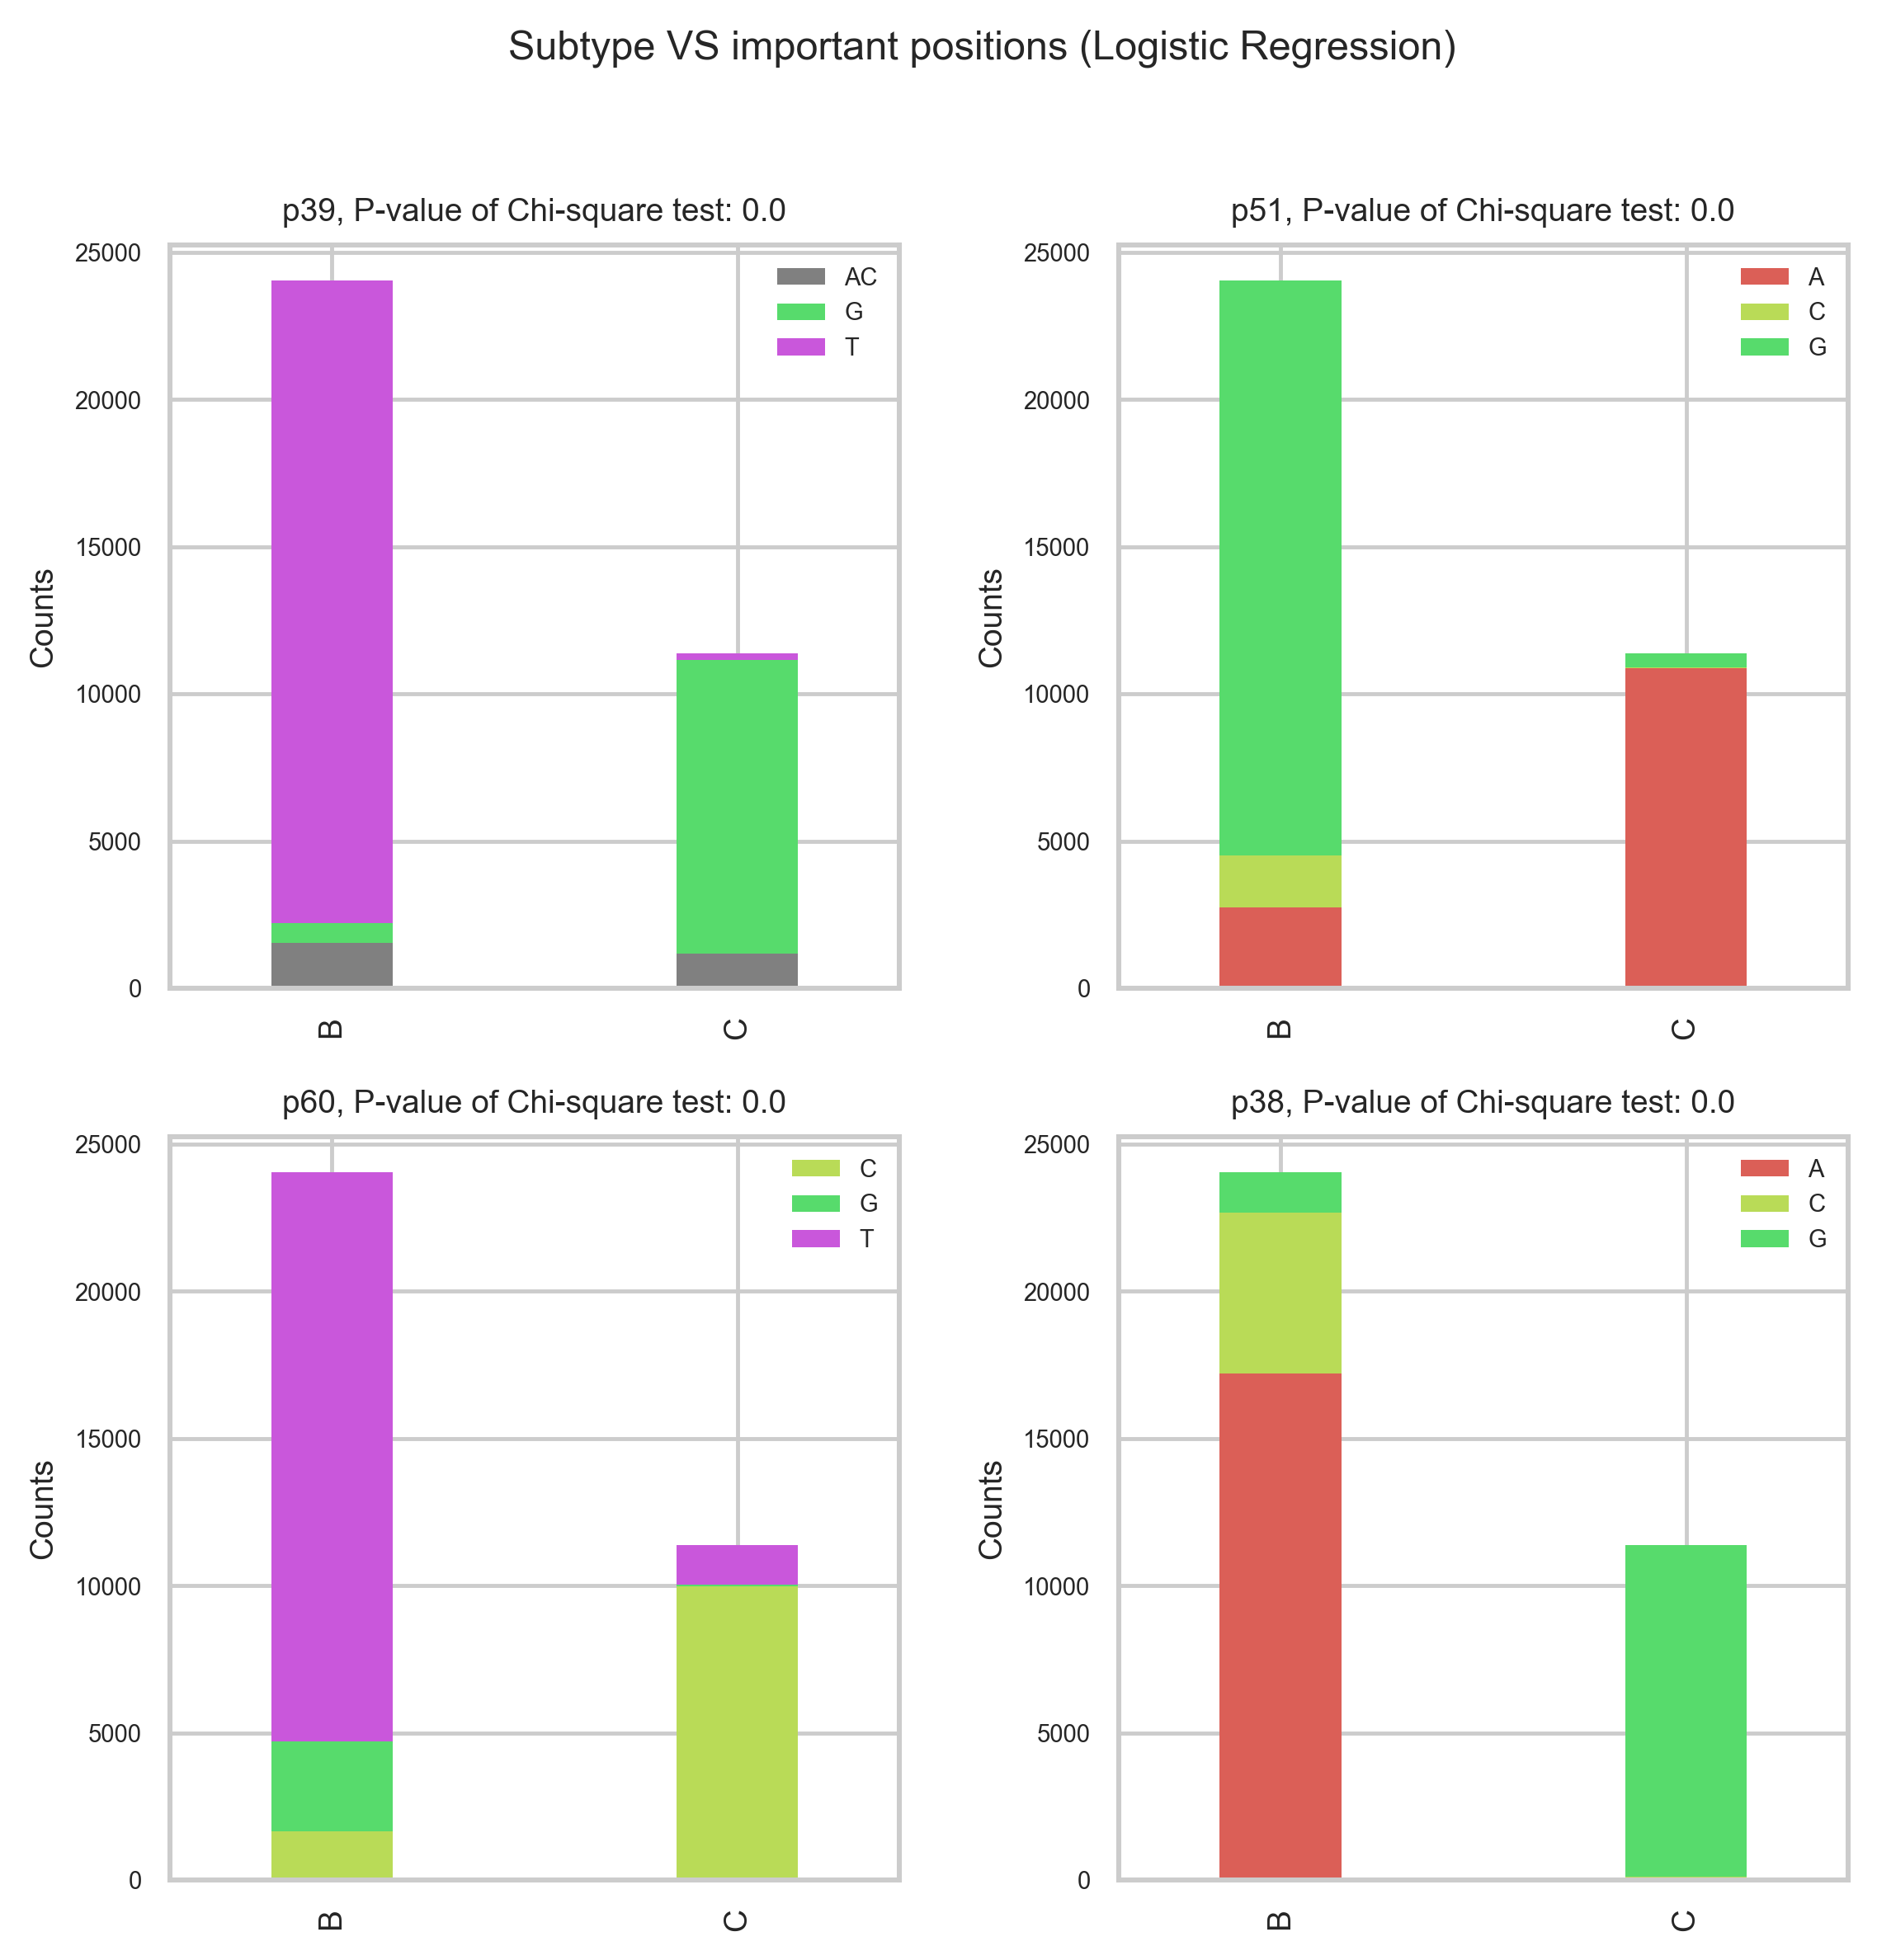

In [21]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

meanDone


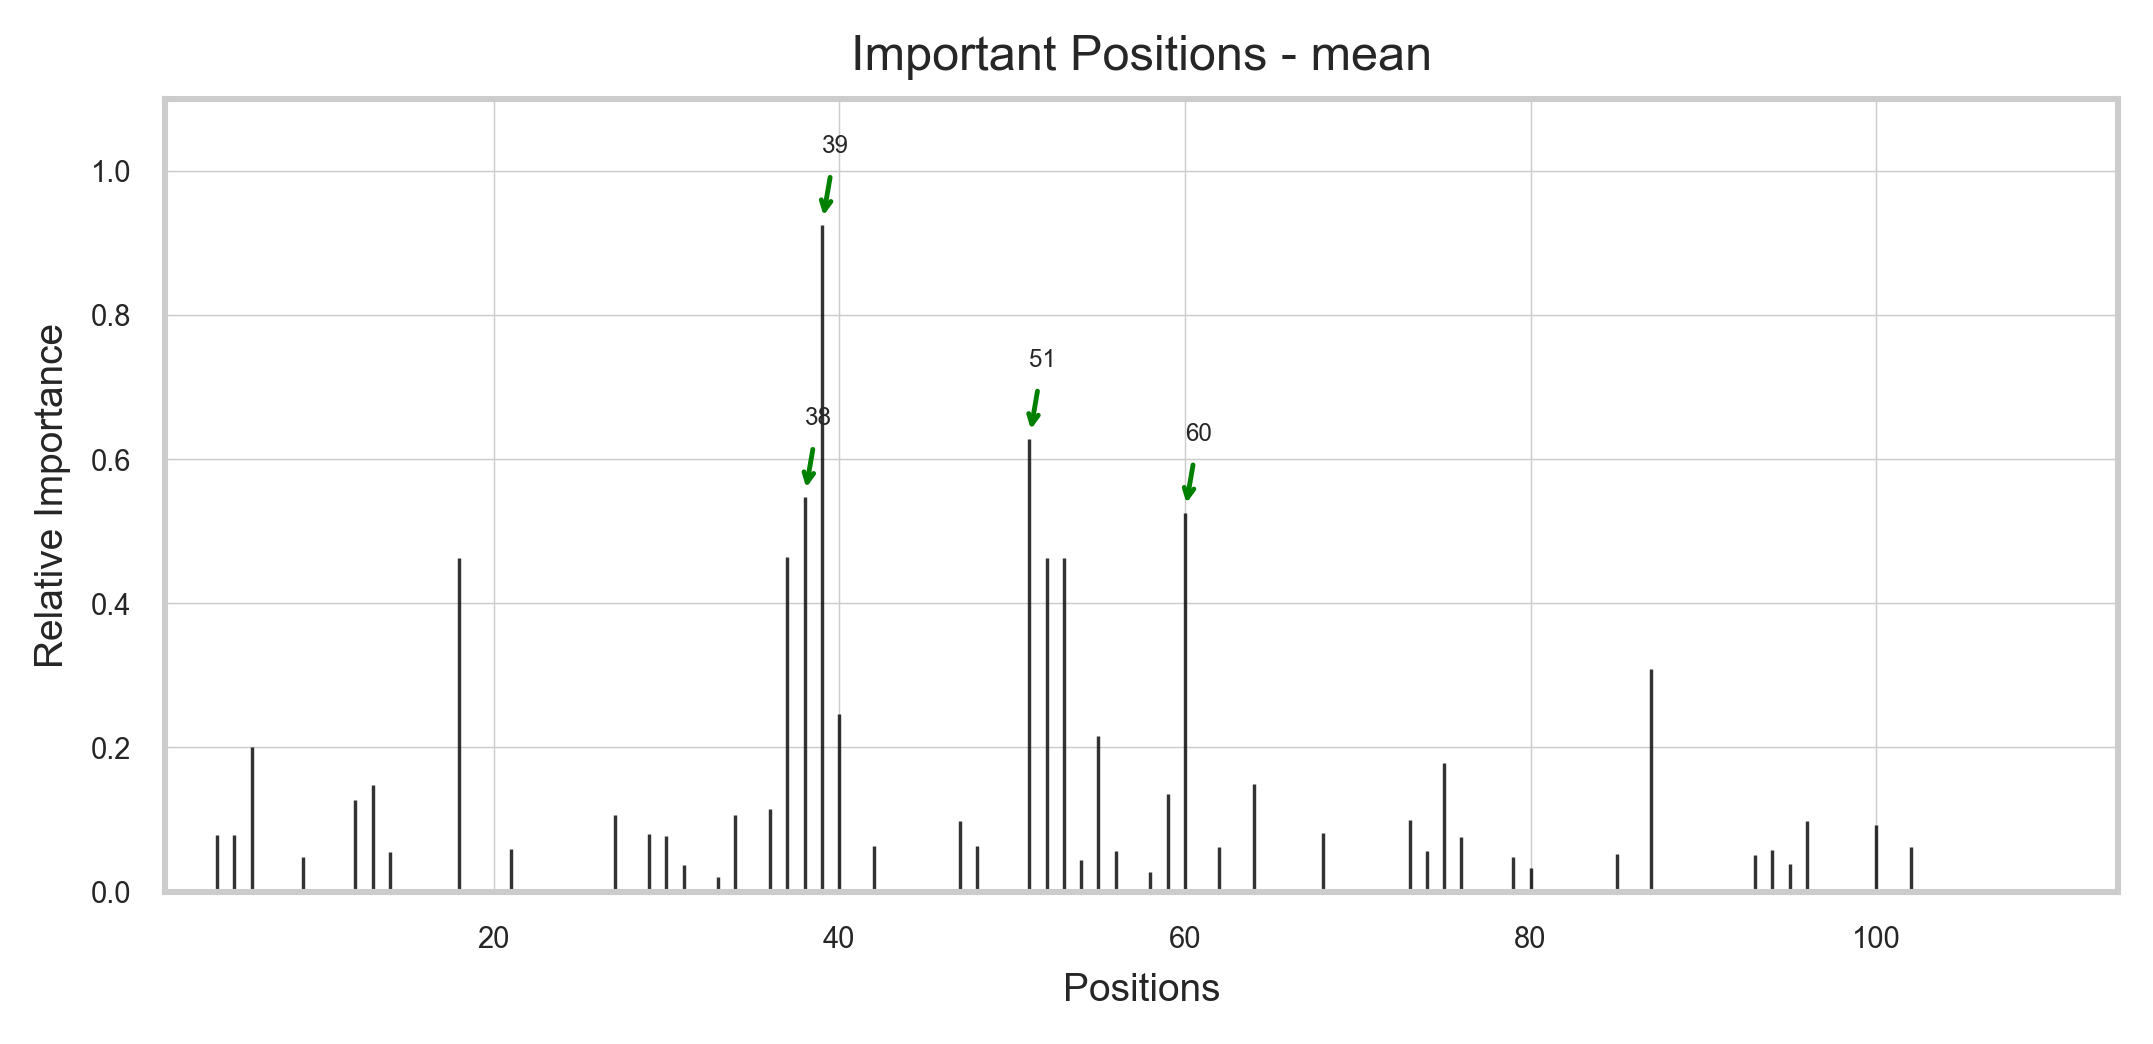

In [22]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,
            model_name= 'mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

<span style="color:red">**Running the next cell will produce individual plots for all of the positions in you sequence.**</span>

{'p51': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p51, P-value: 0.0'}, ylabel='Counts'>),
 'p60': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p60, P-value: 0.0'}, ylabel='Counts'>),
 'p37': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p37, P-value: 0.0'}, ylabel='Counts'>),
 'p39': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p39, P-value: 0.0'}, ylabel='Counts'>),
 'p87': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p87, P-value: 0.0'}, ylabel='Counts'>),
 'p38': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p38, P-value: 0.0'}, ylabel='Counts'>),
 'p75': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p75, P-value: 0.0'}, ylabel='Counts'>),
 'p55': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title={'center':'p55, P-value: 0.0'}, ylabel='Counts'>),
 'p6': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot:title

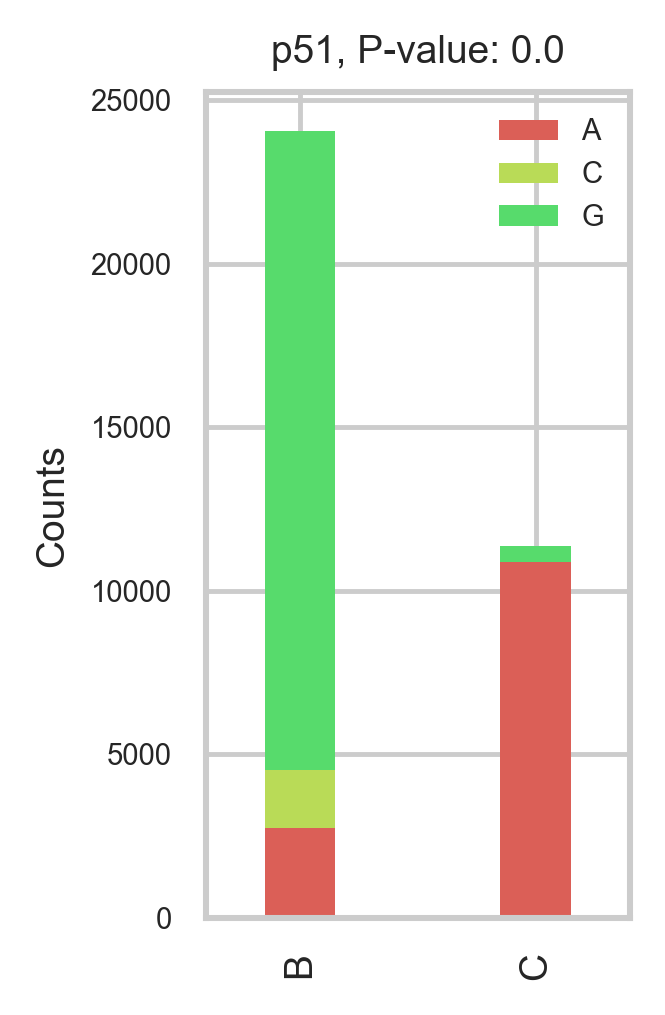

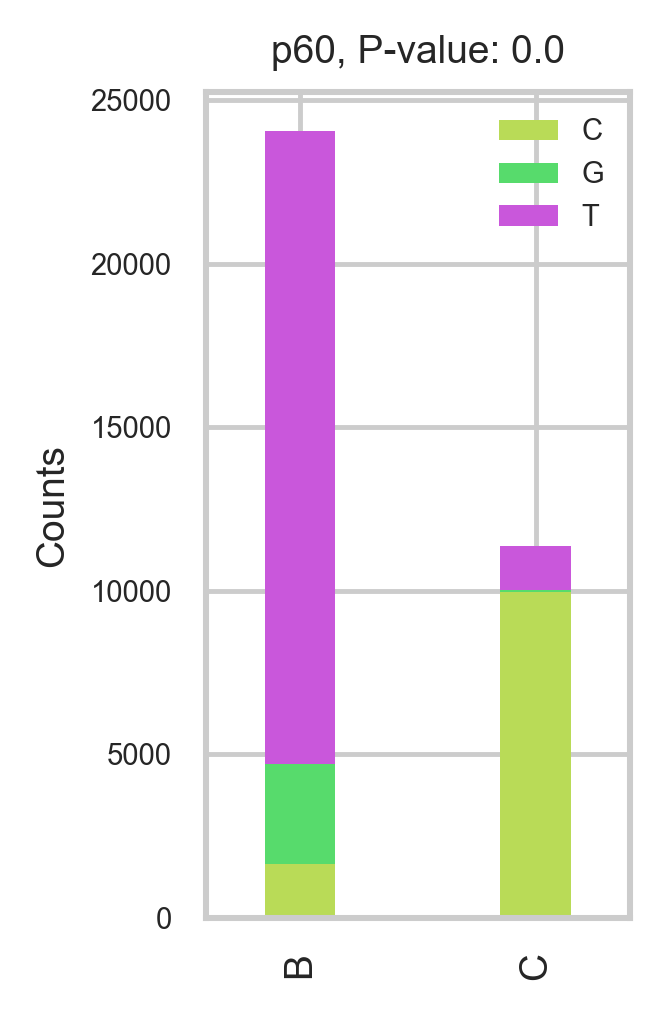

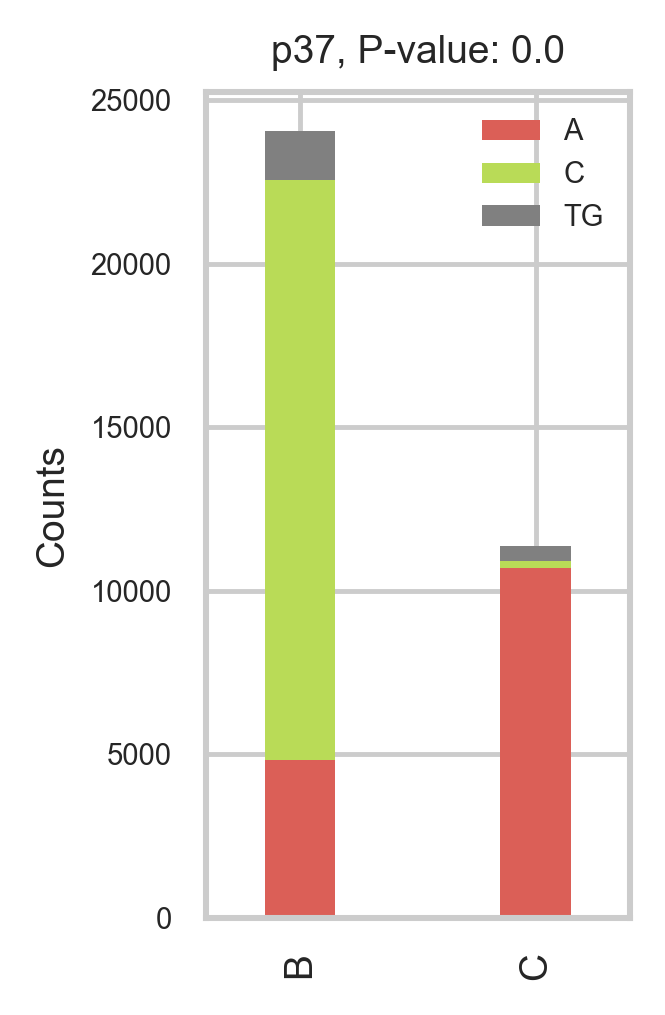

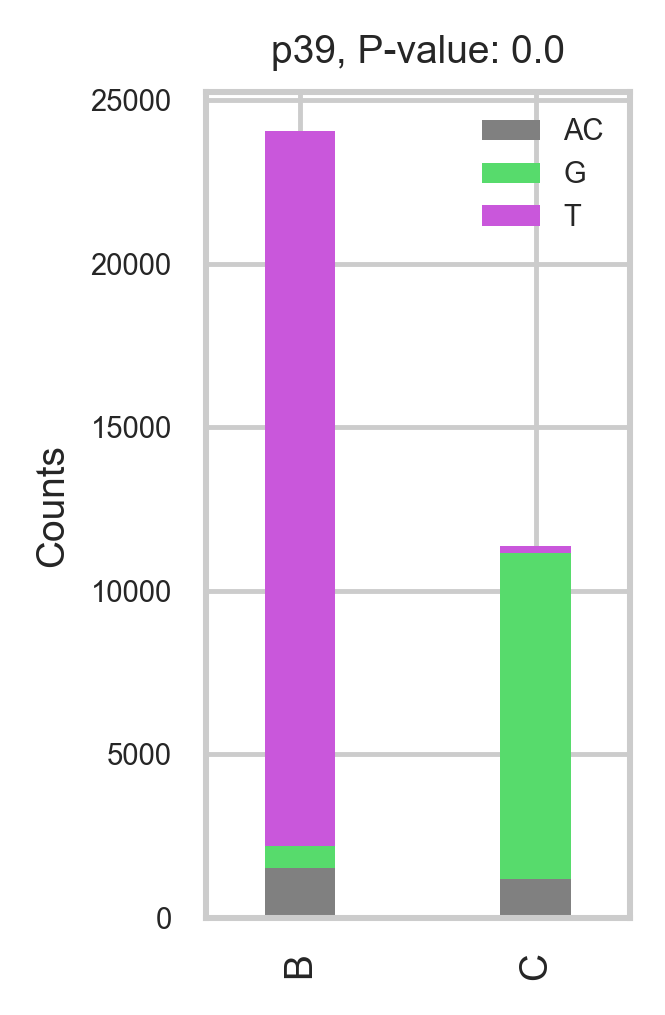

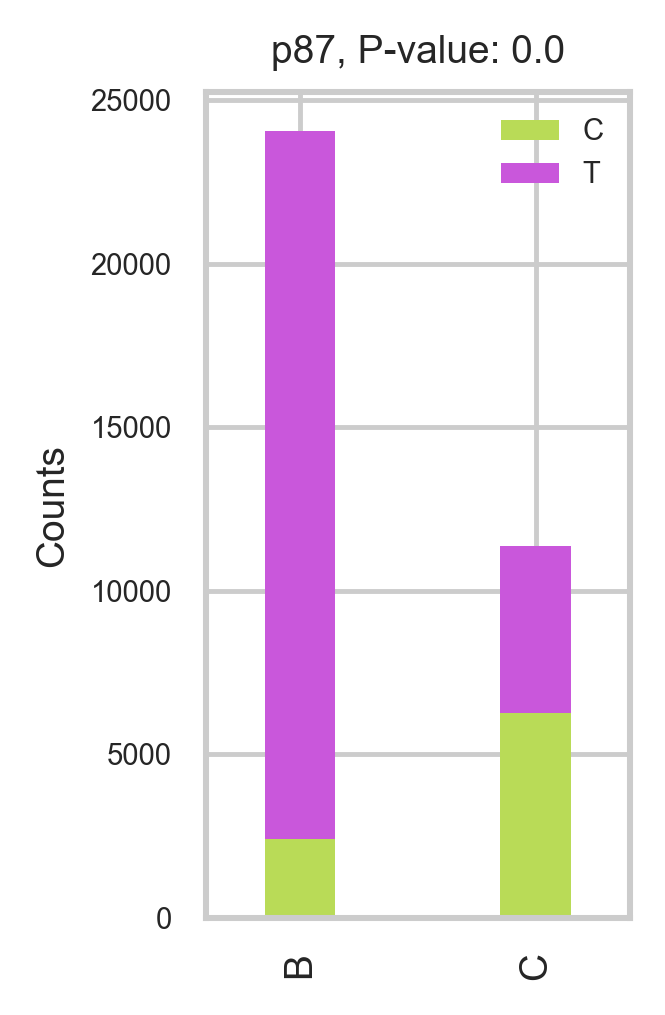

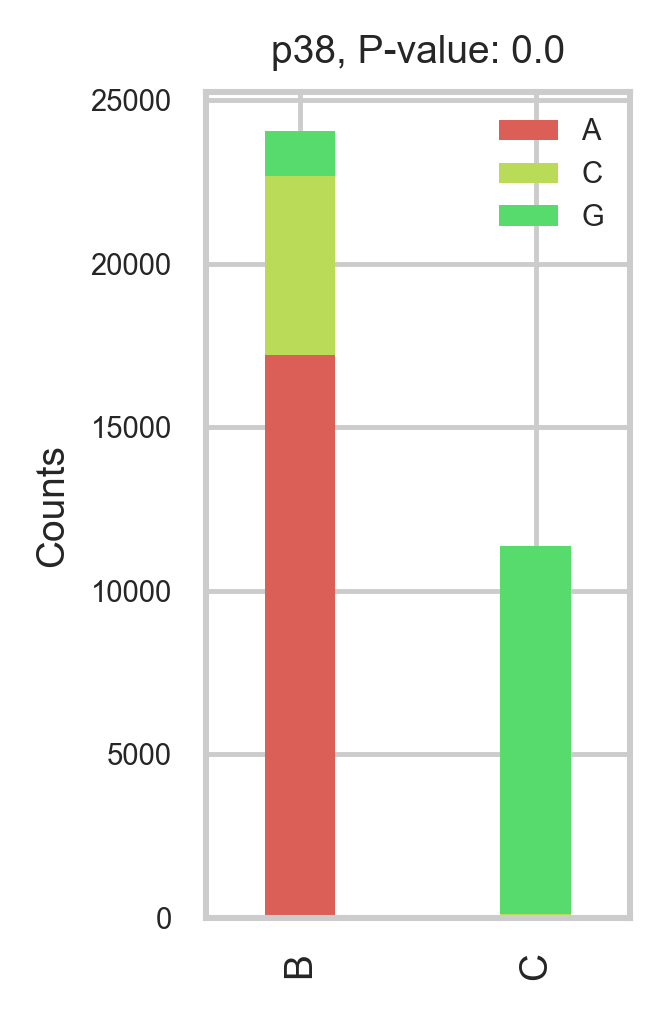

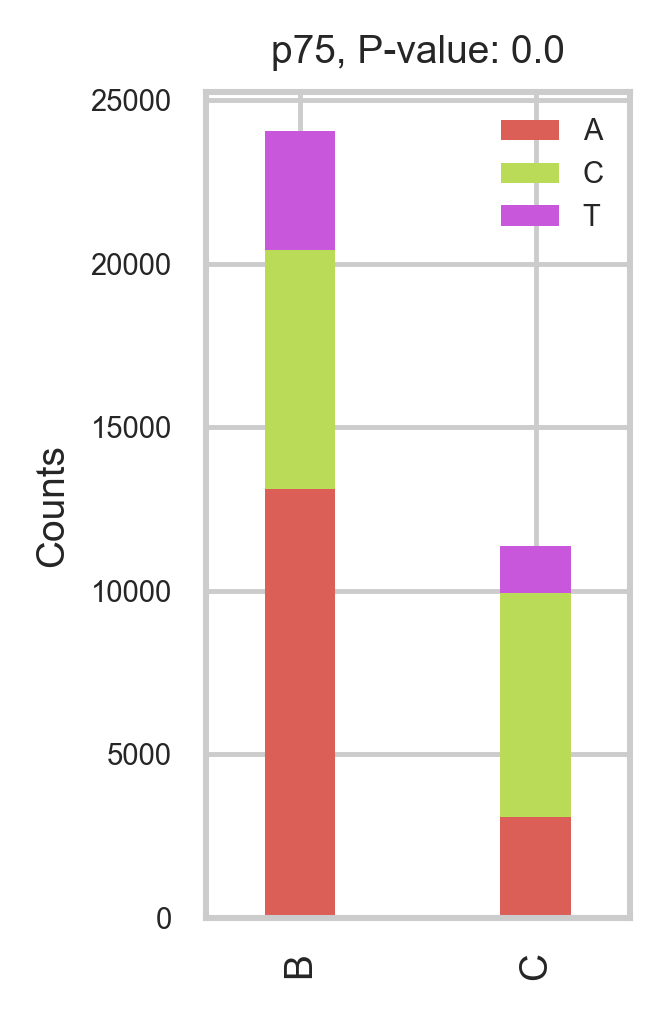

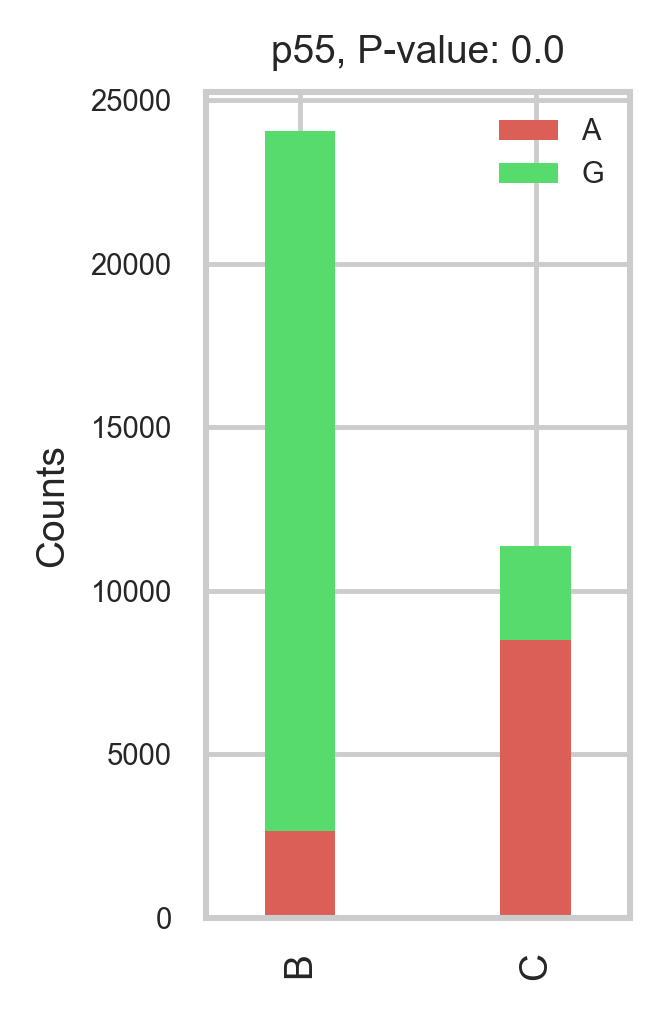

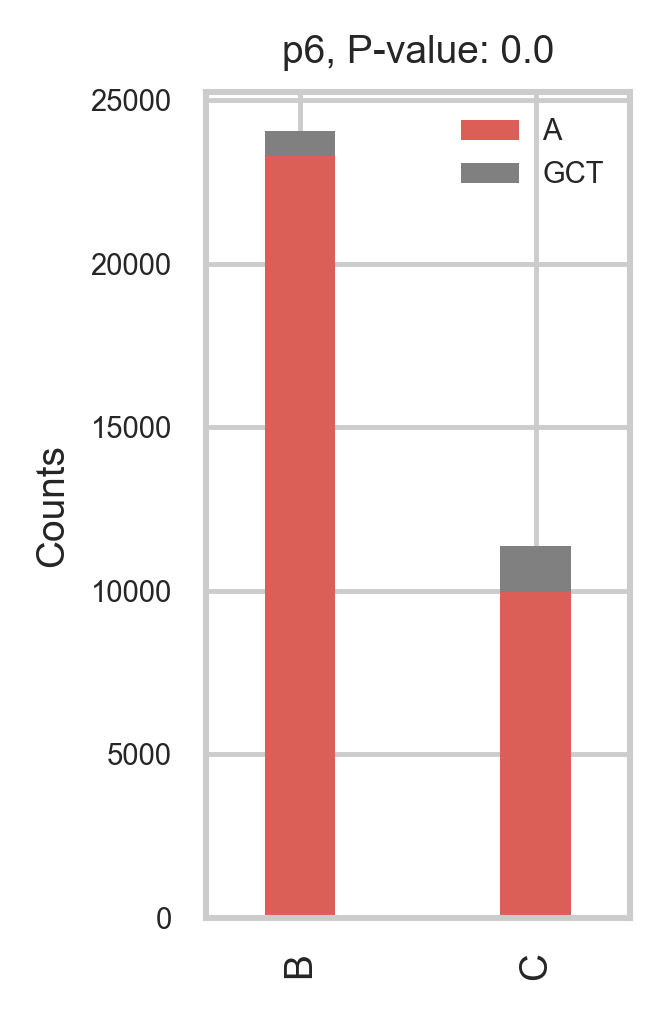

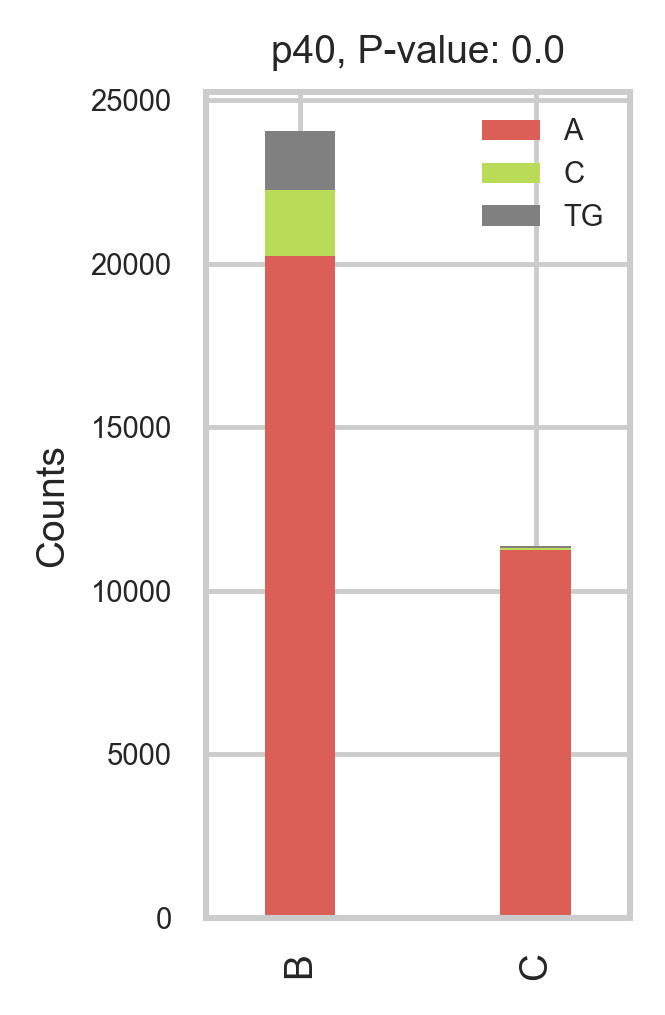

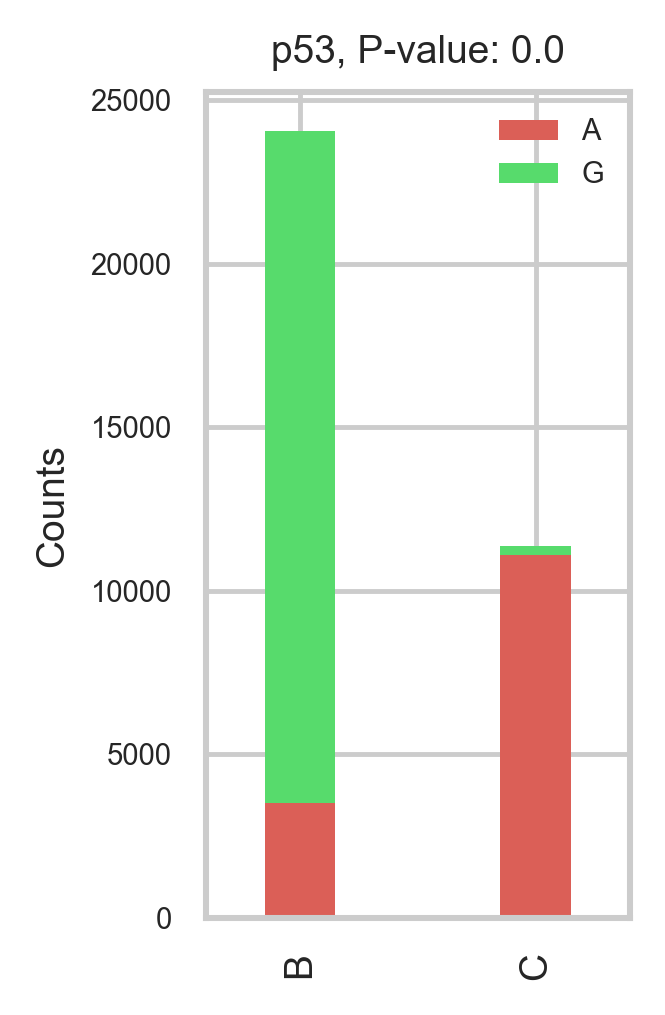

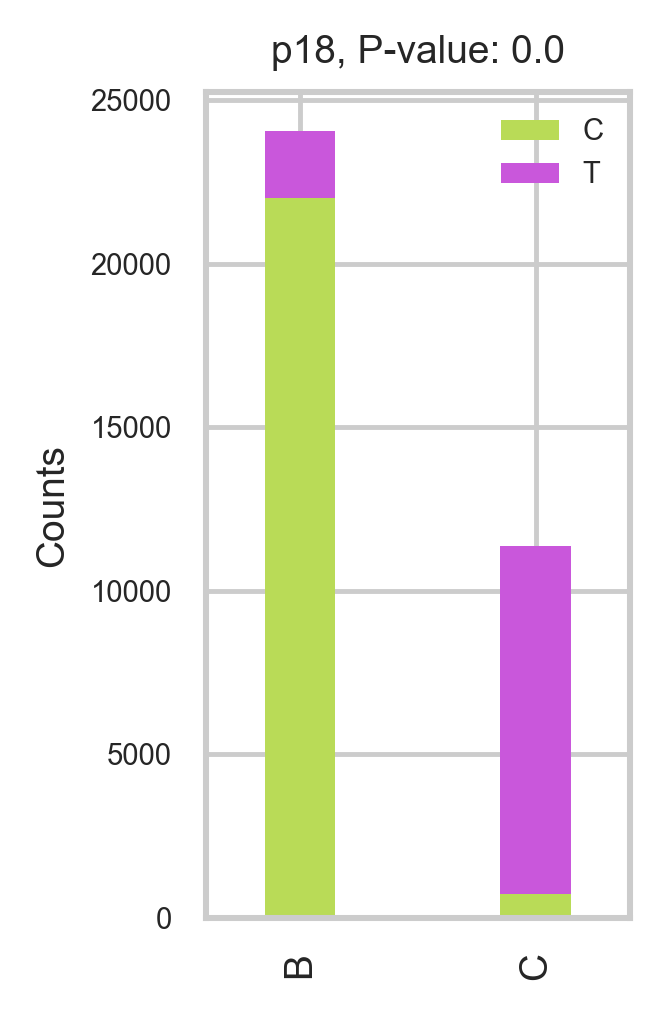

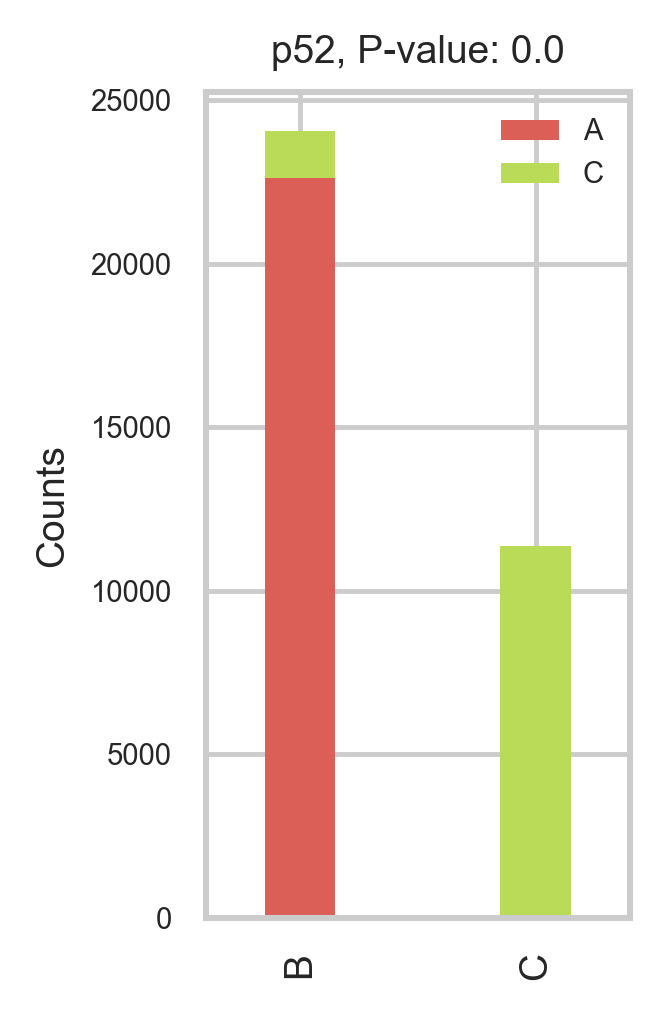

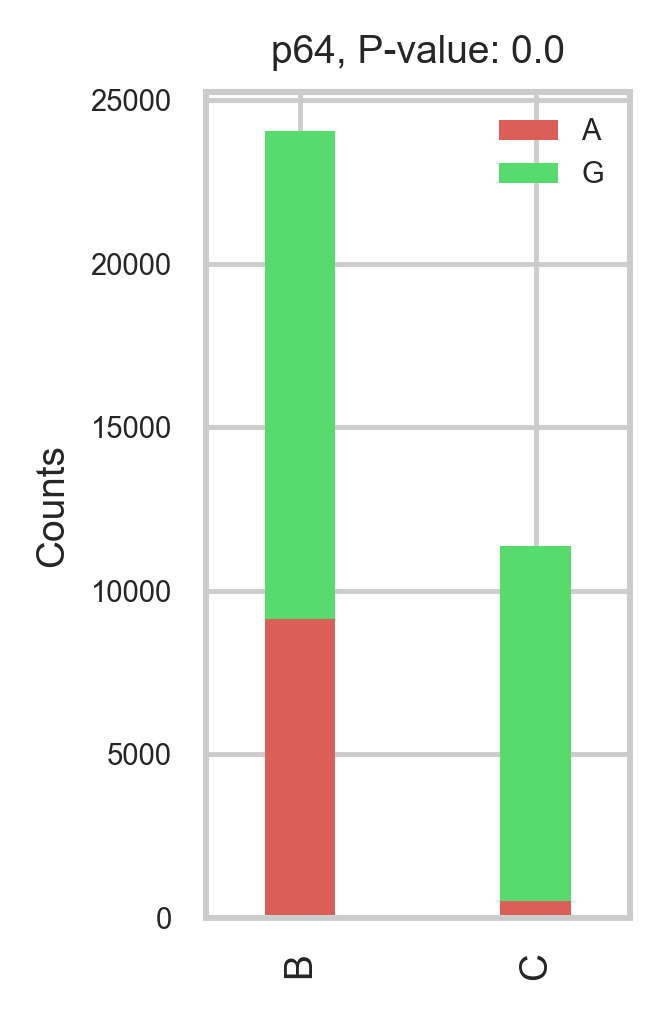

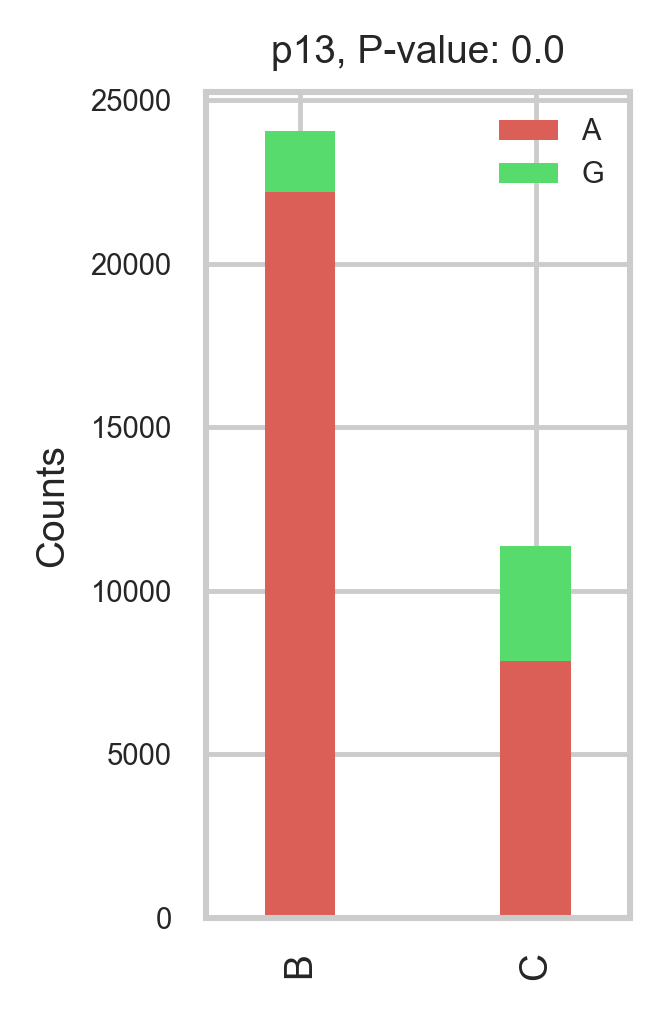

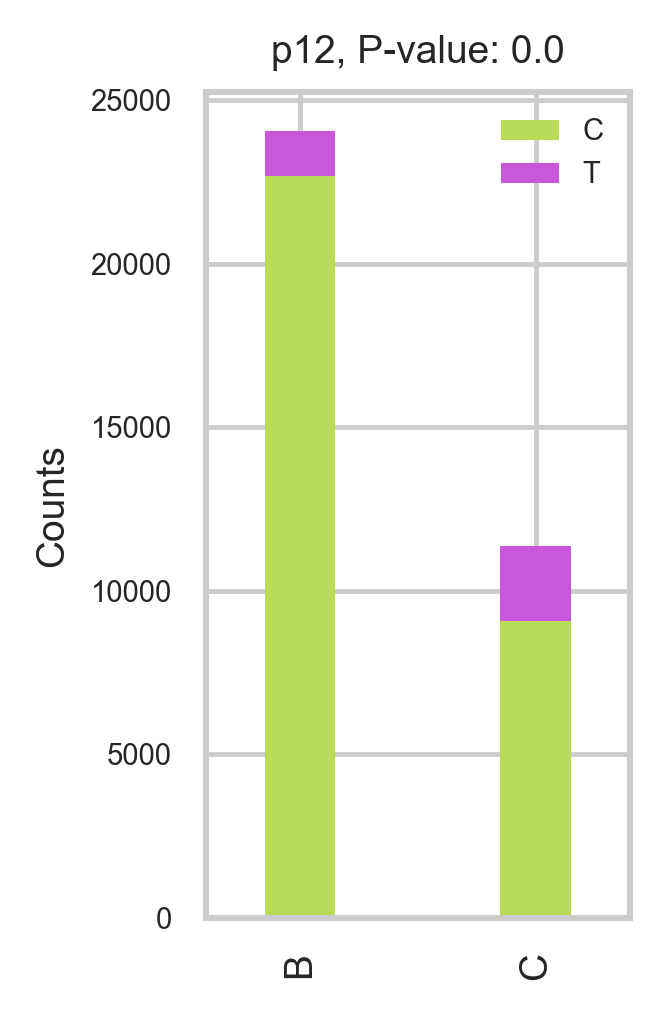

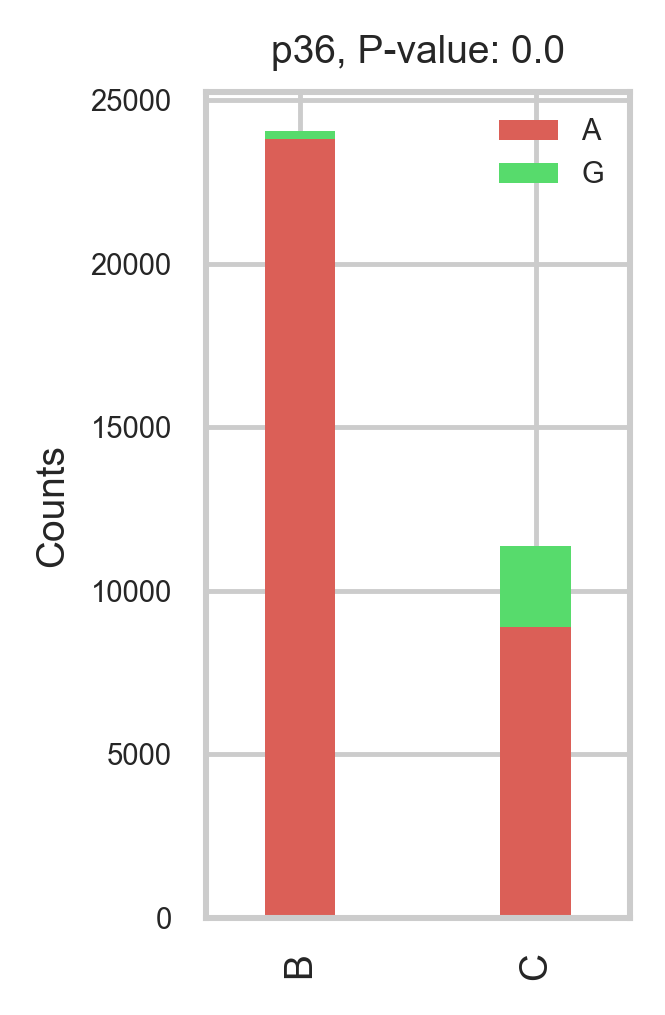

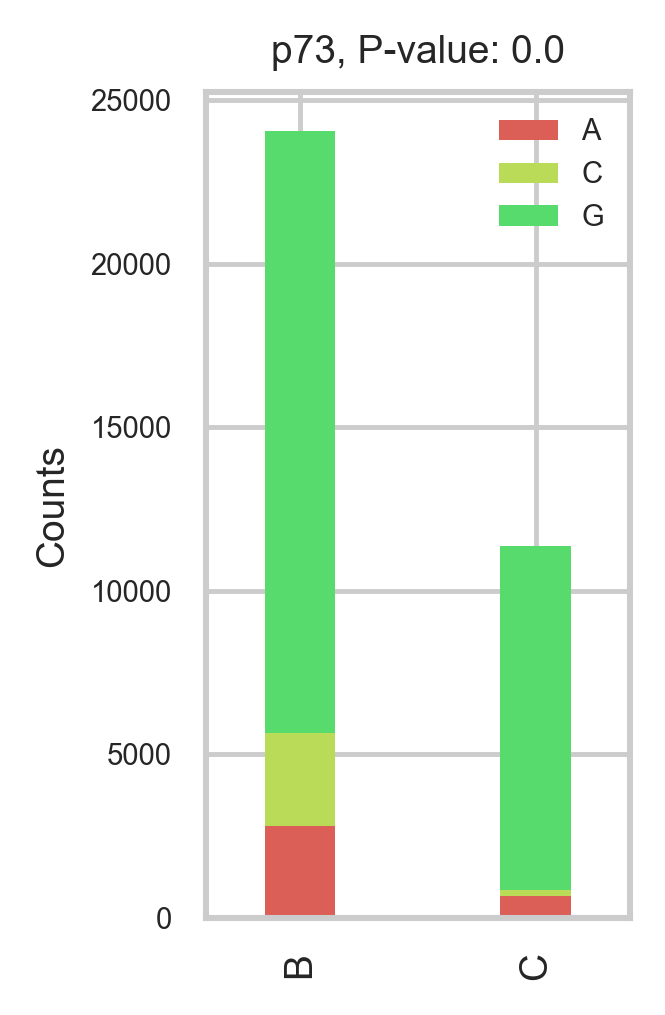

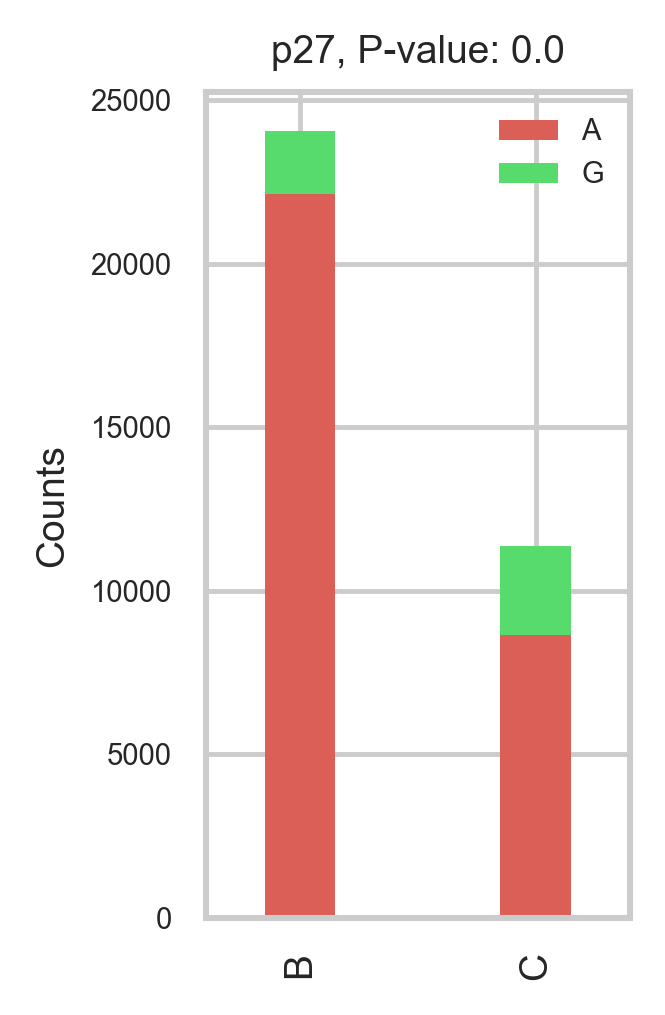

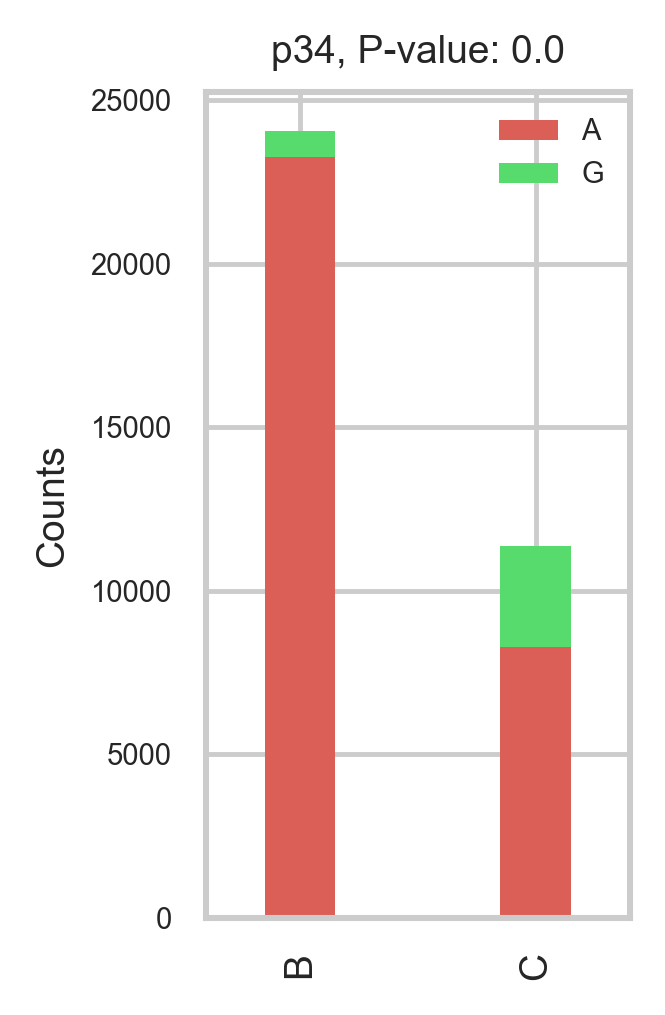

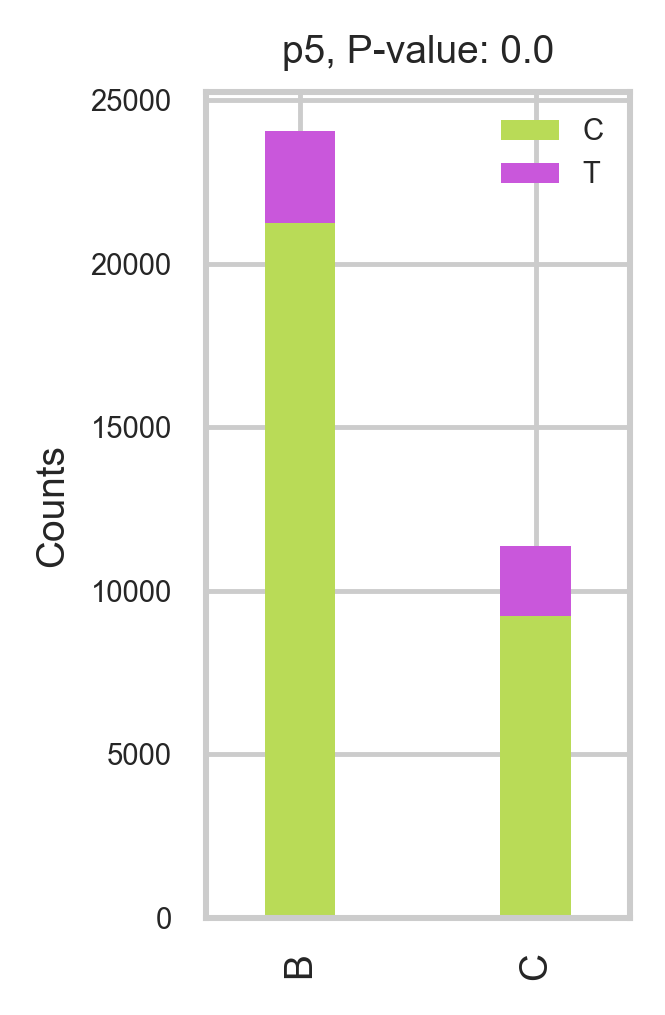

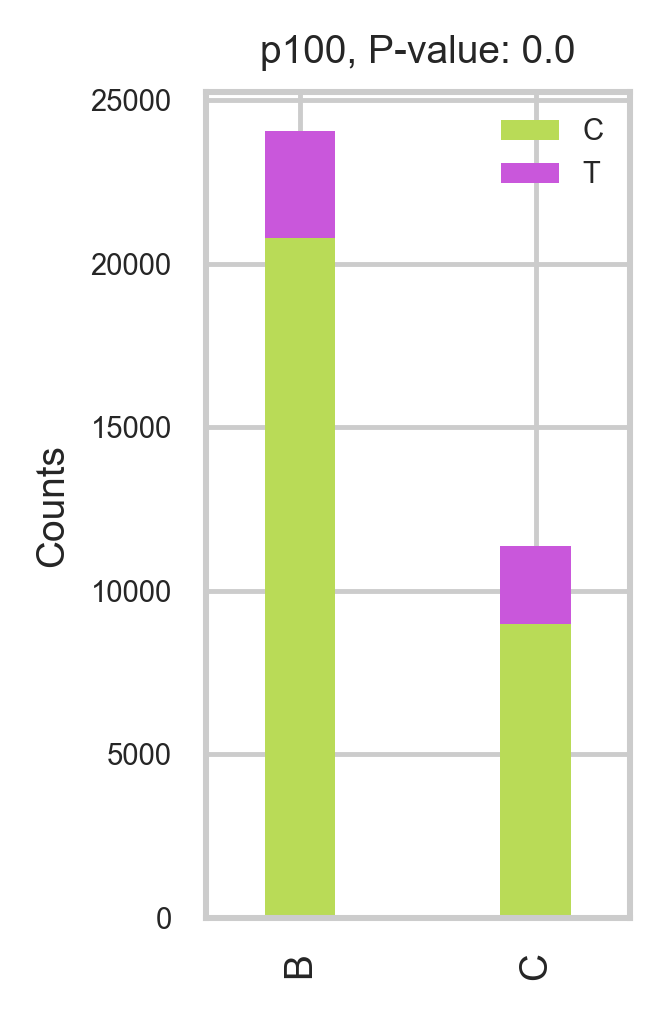

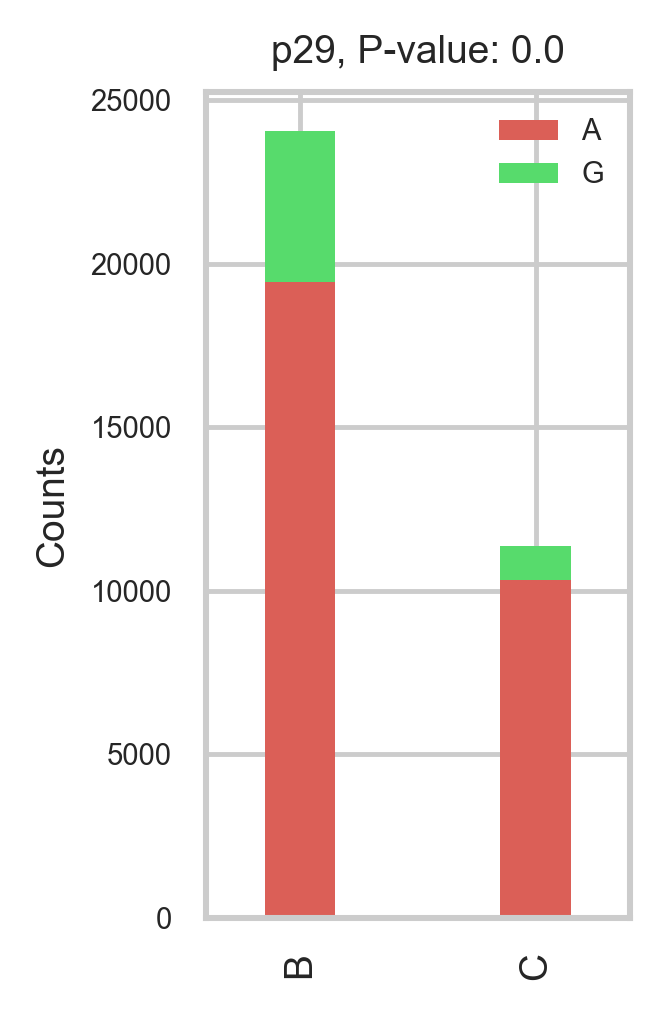

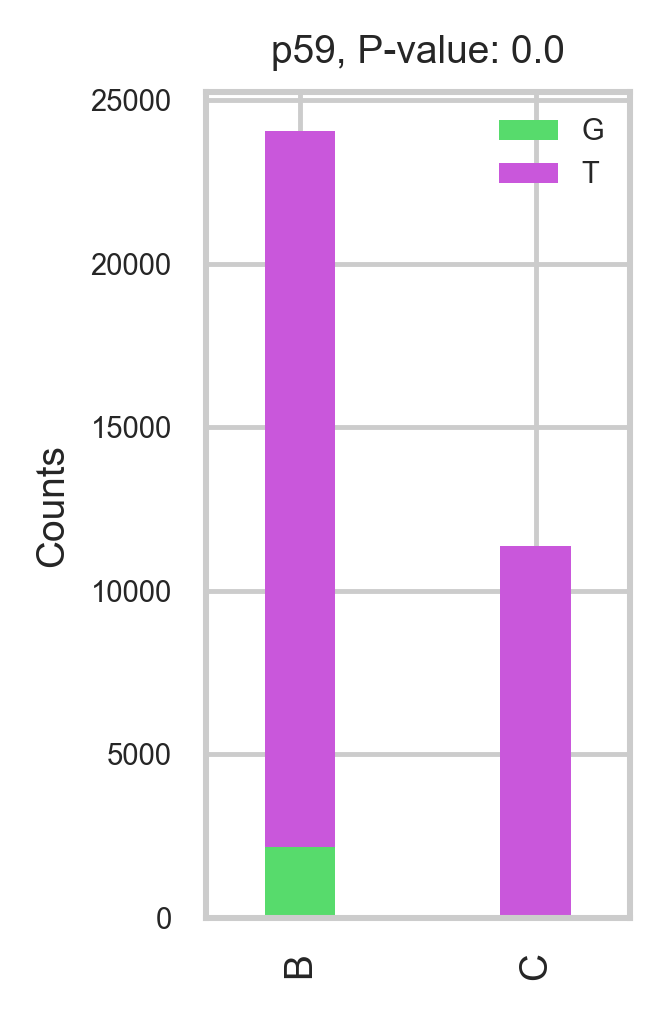

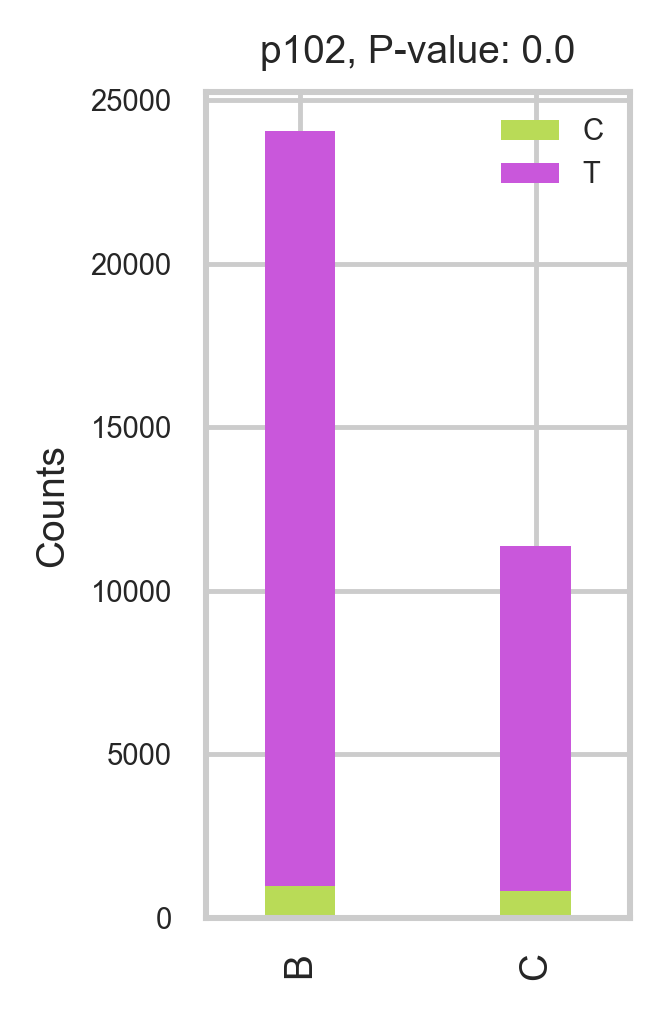

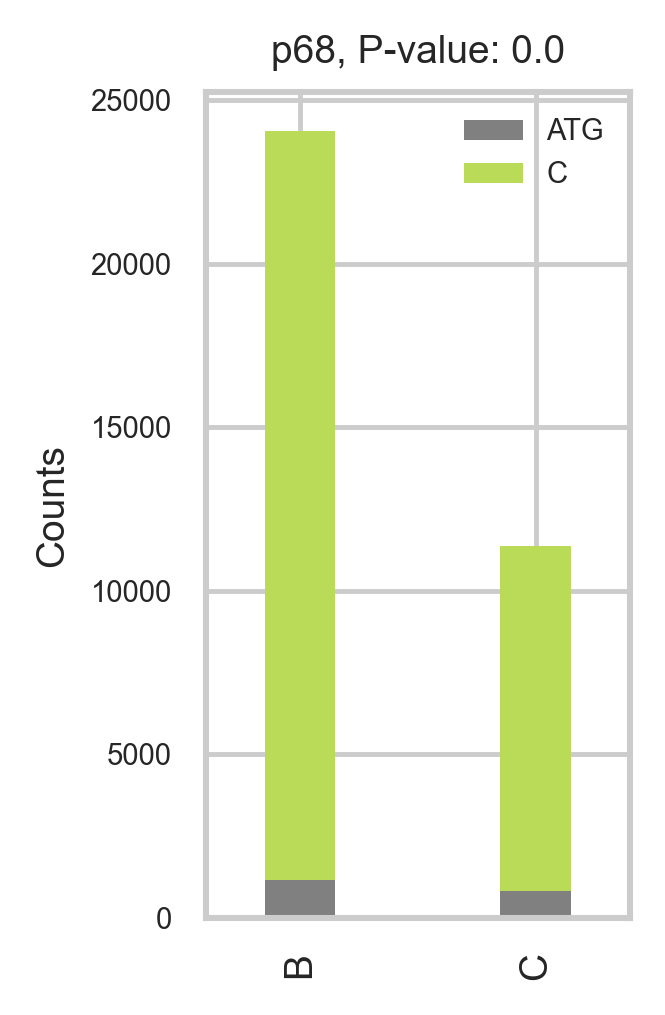

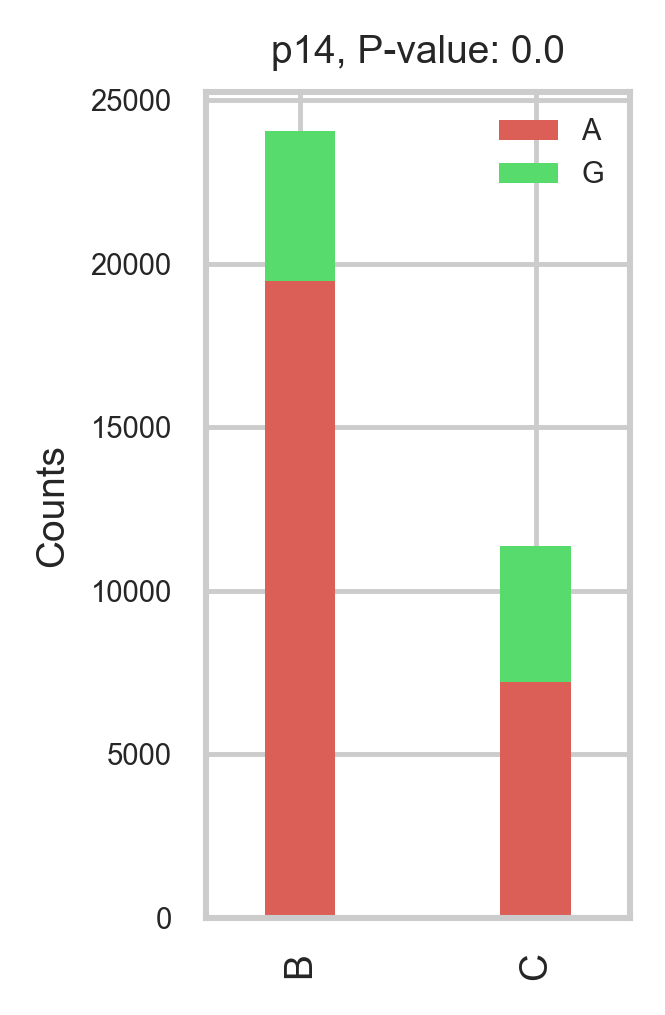

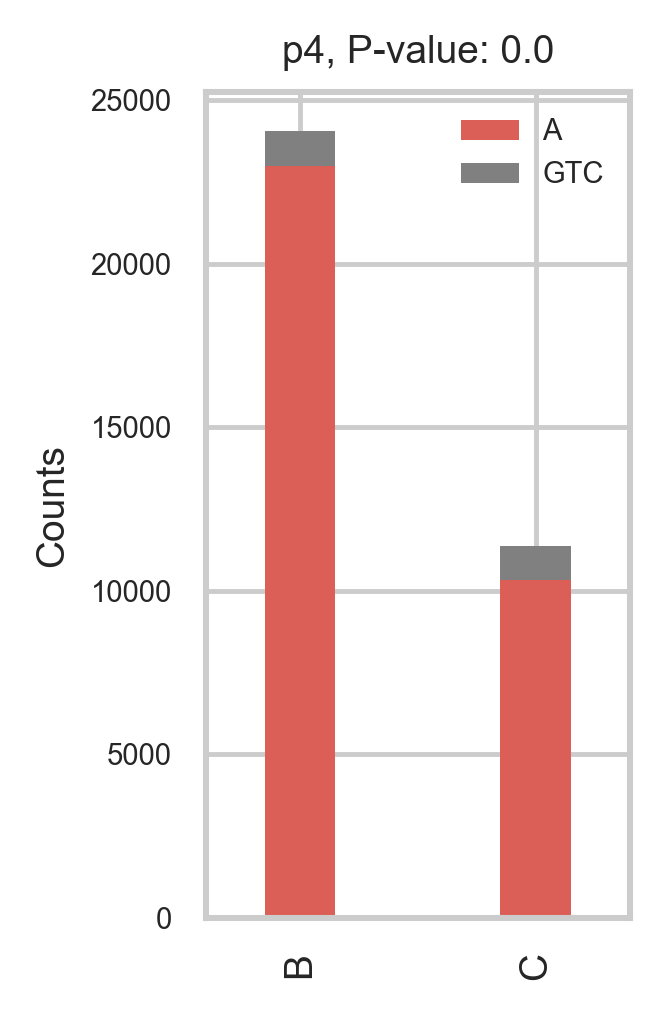

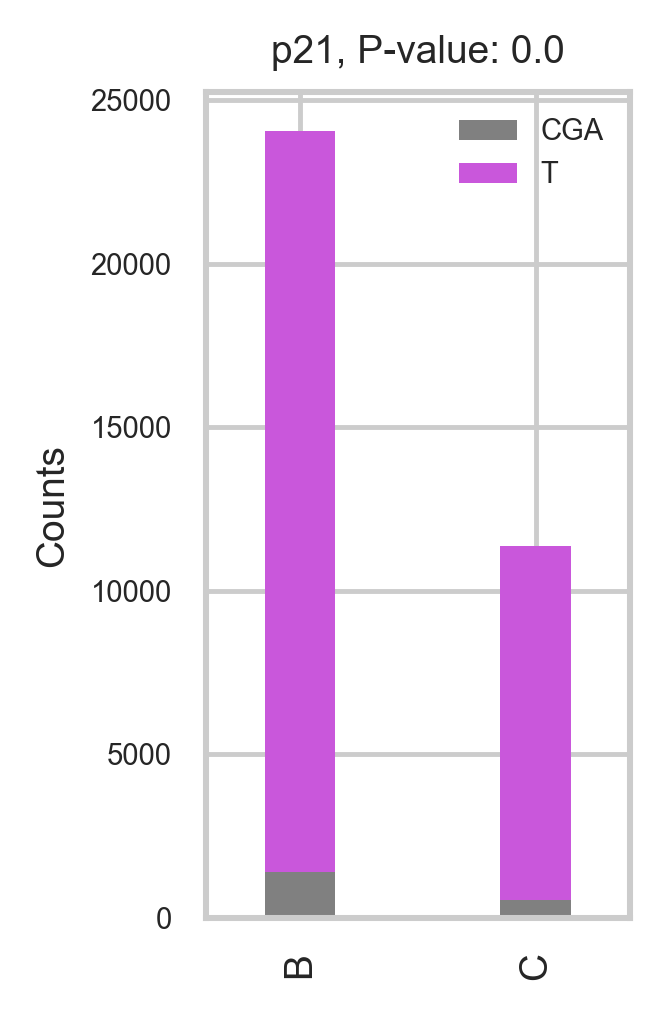

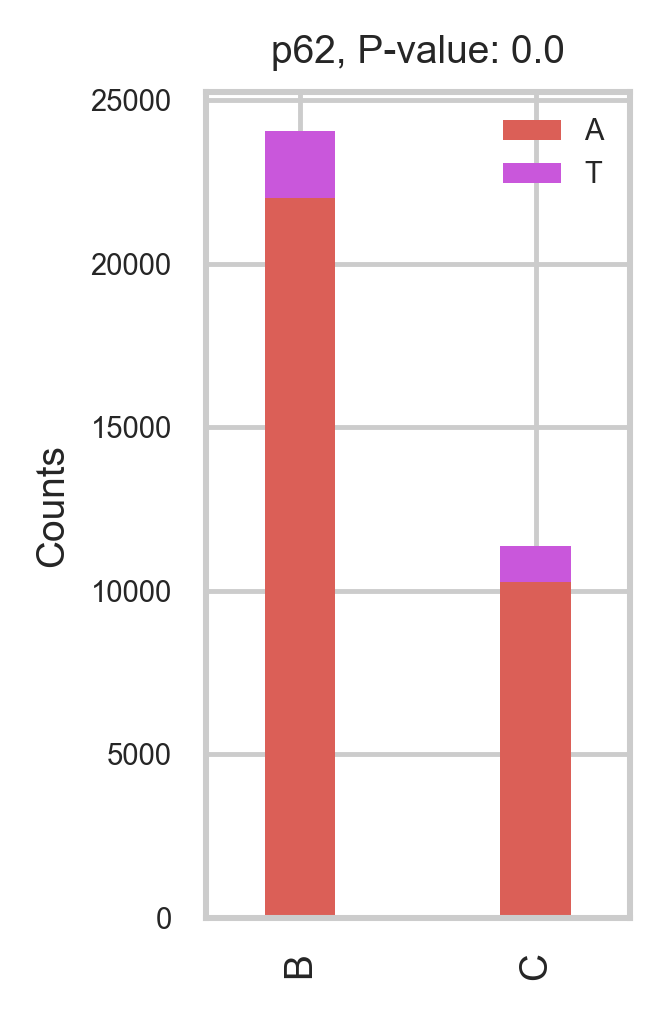

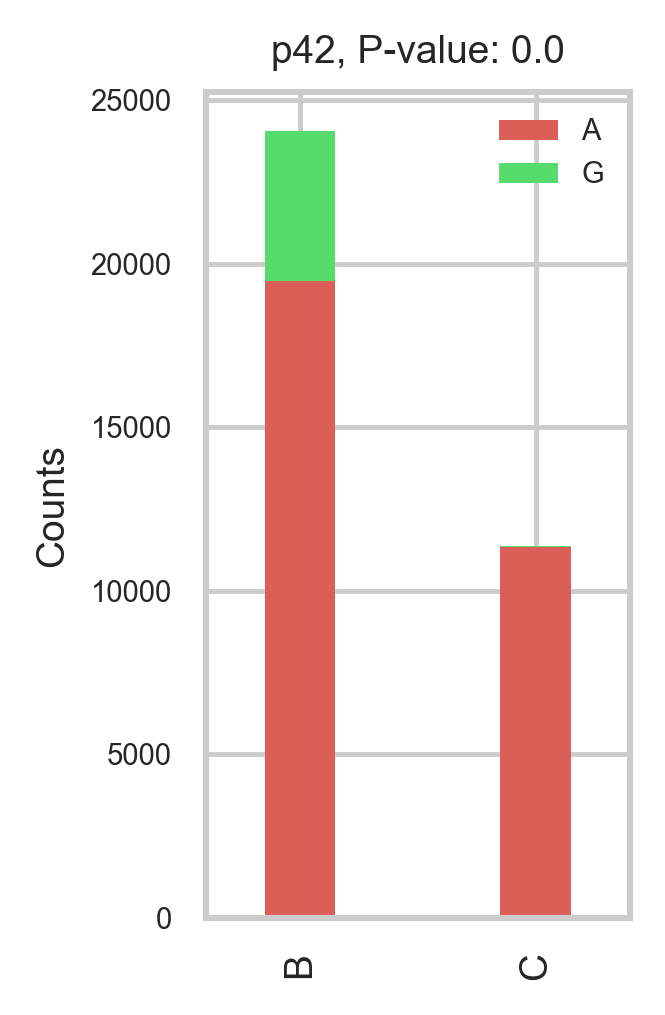

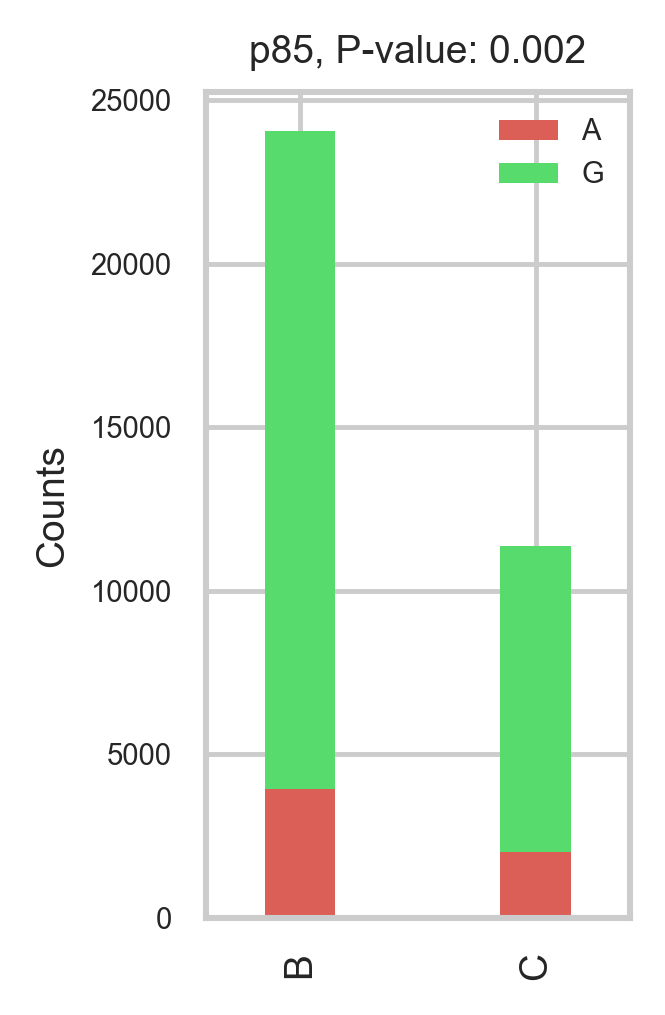

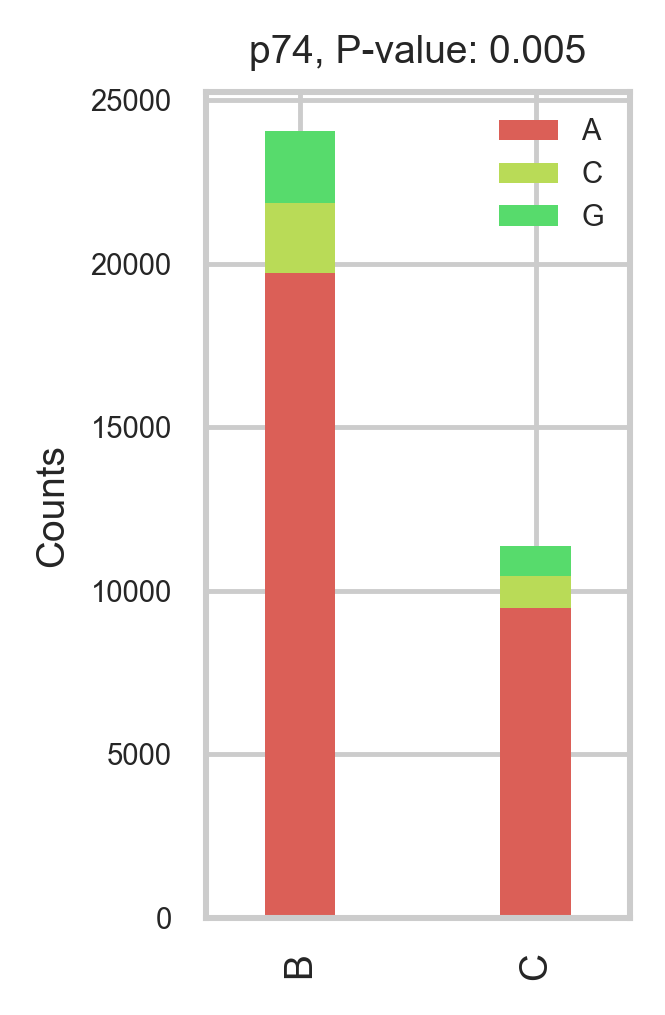

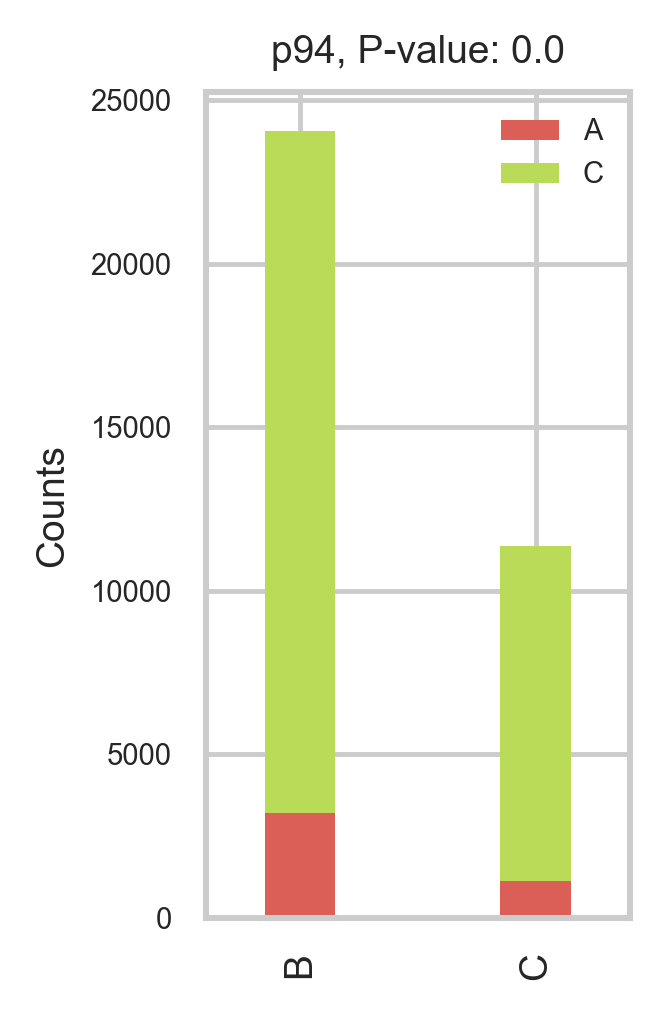

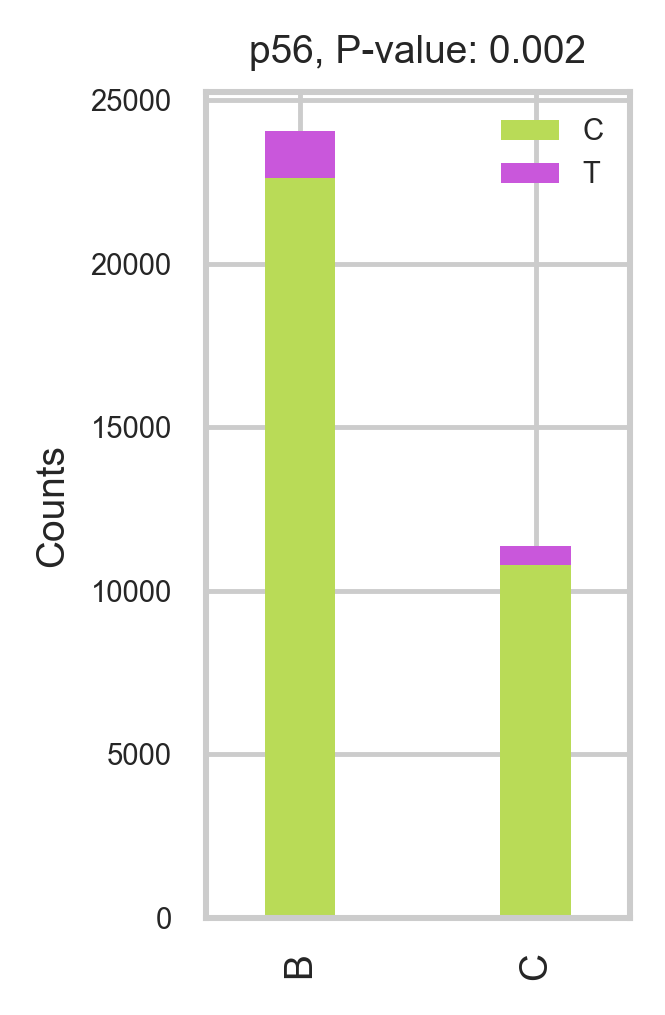

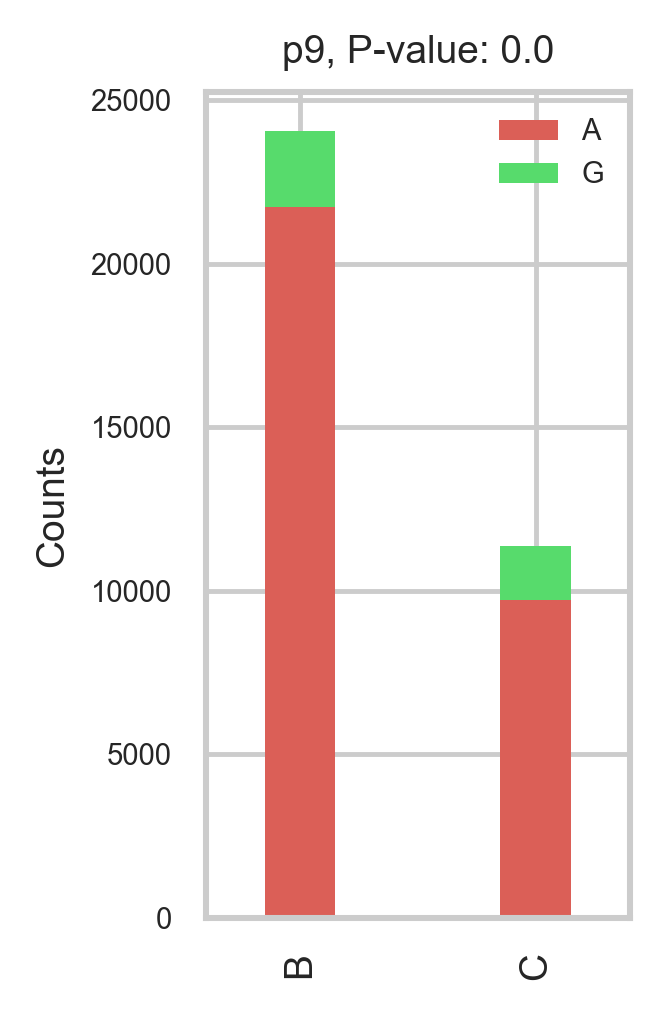

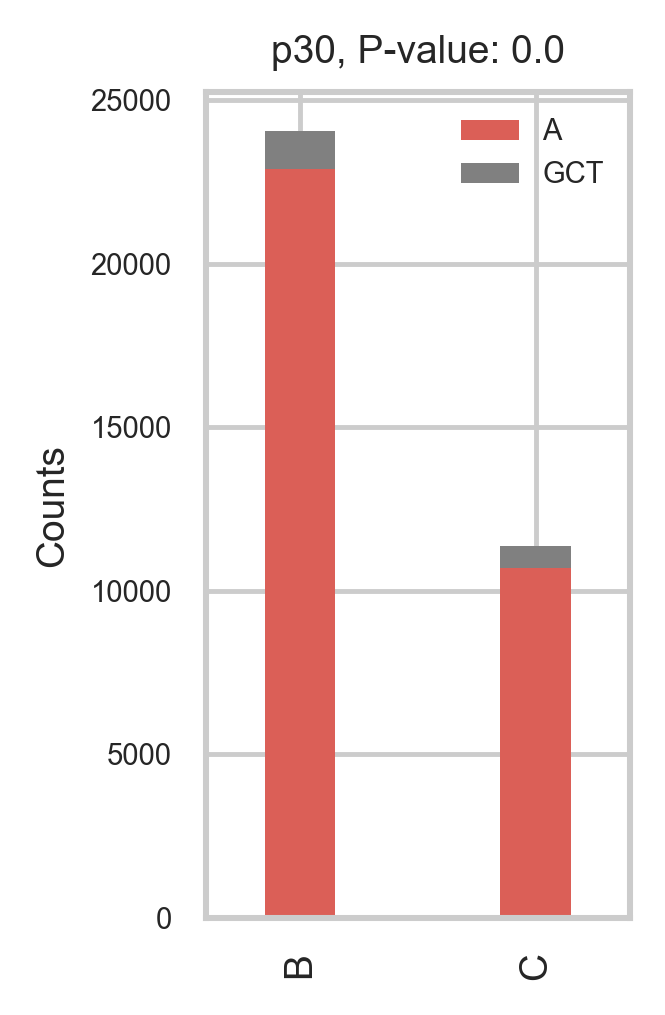

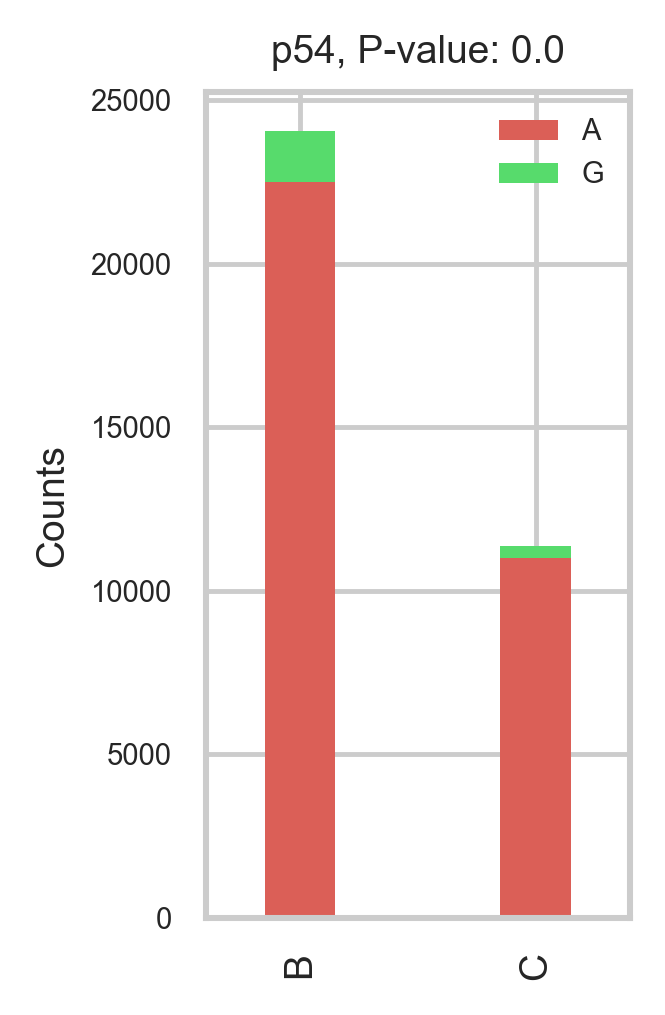

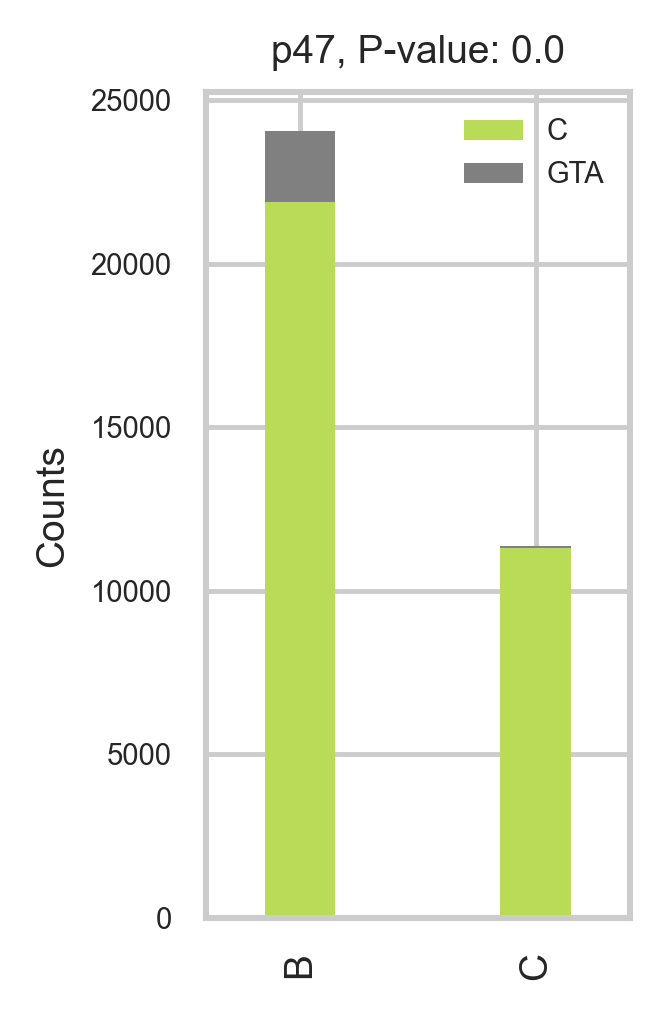

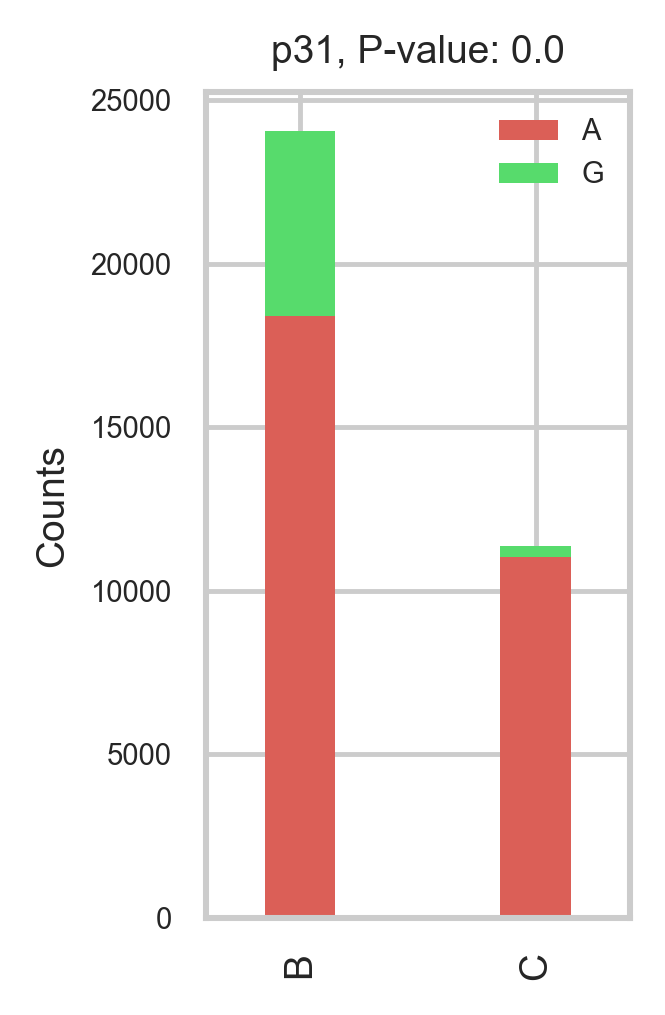

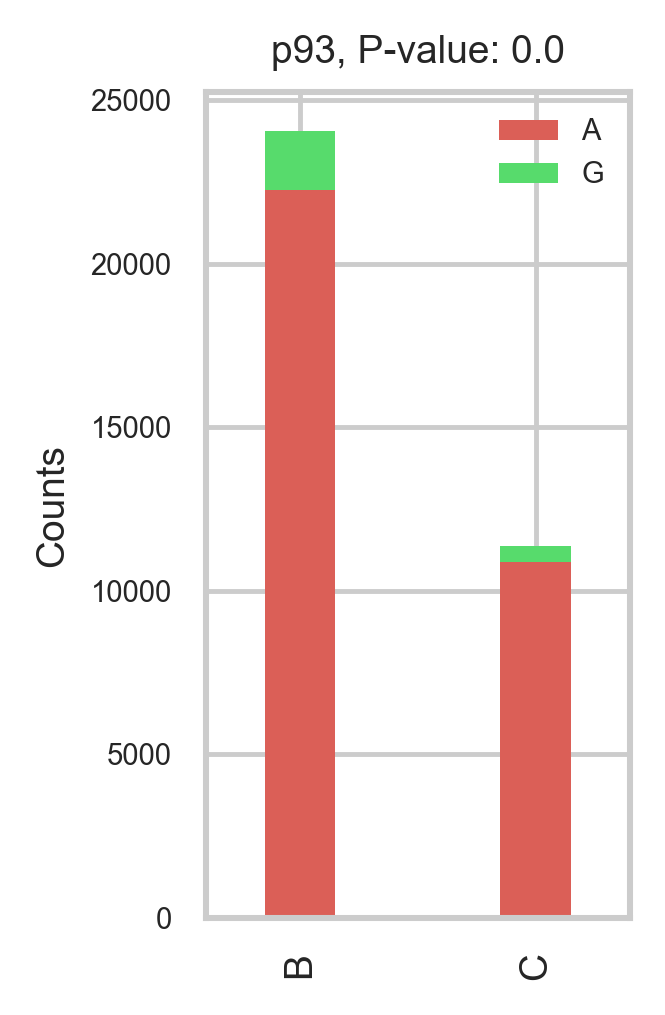

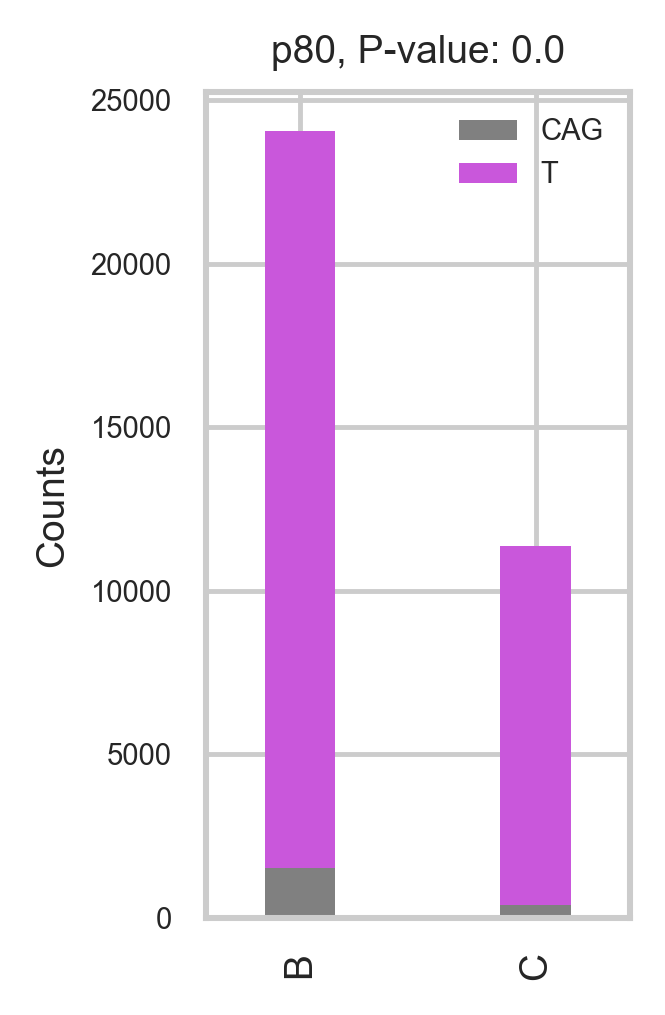

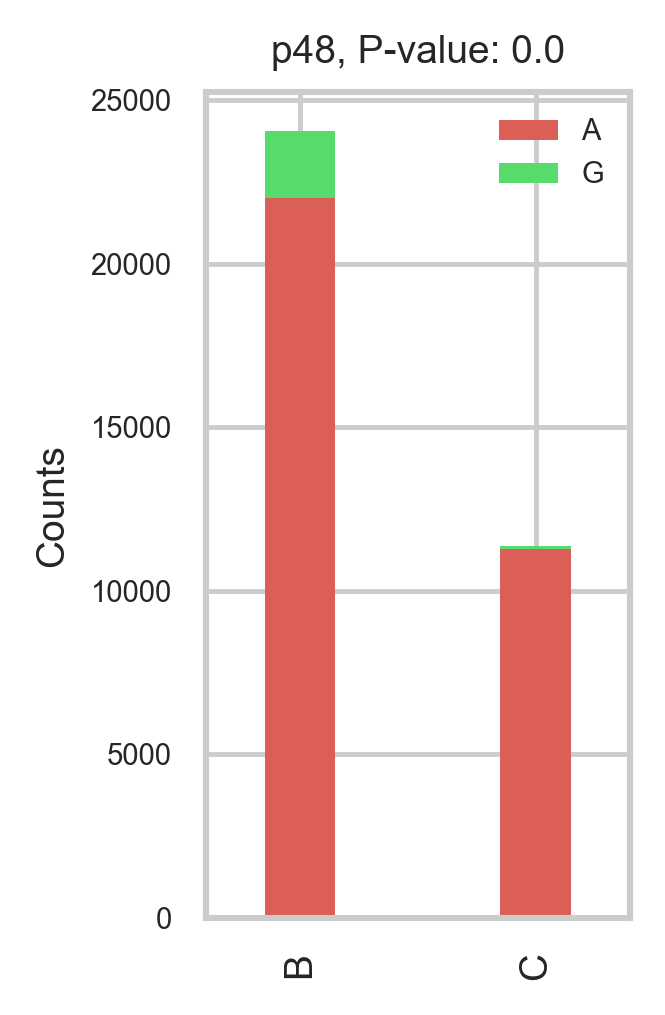

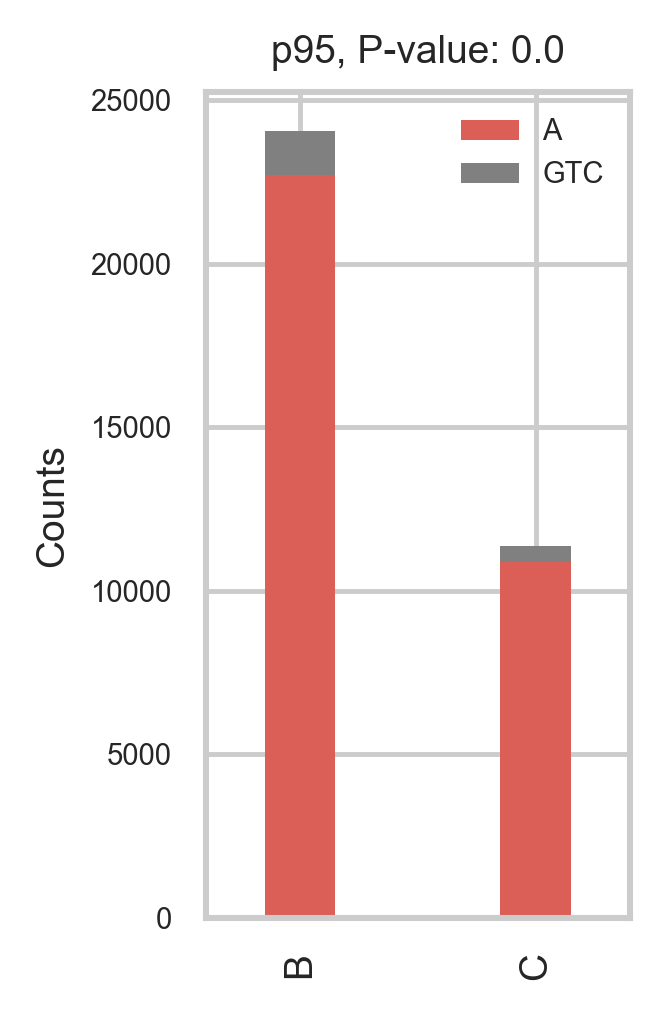

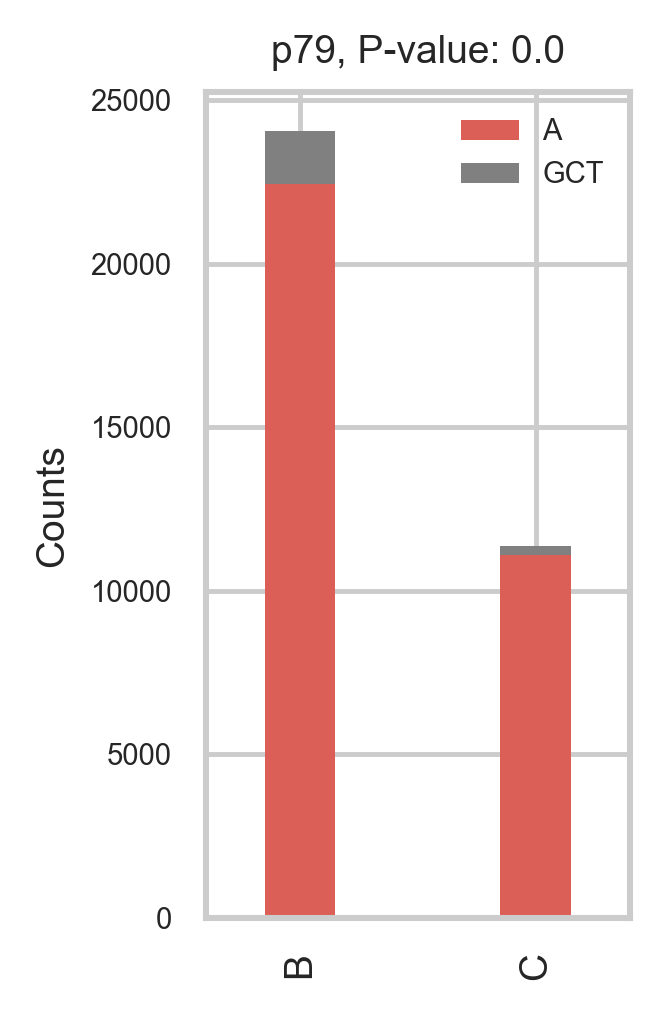

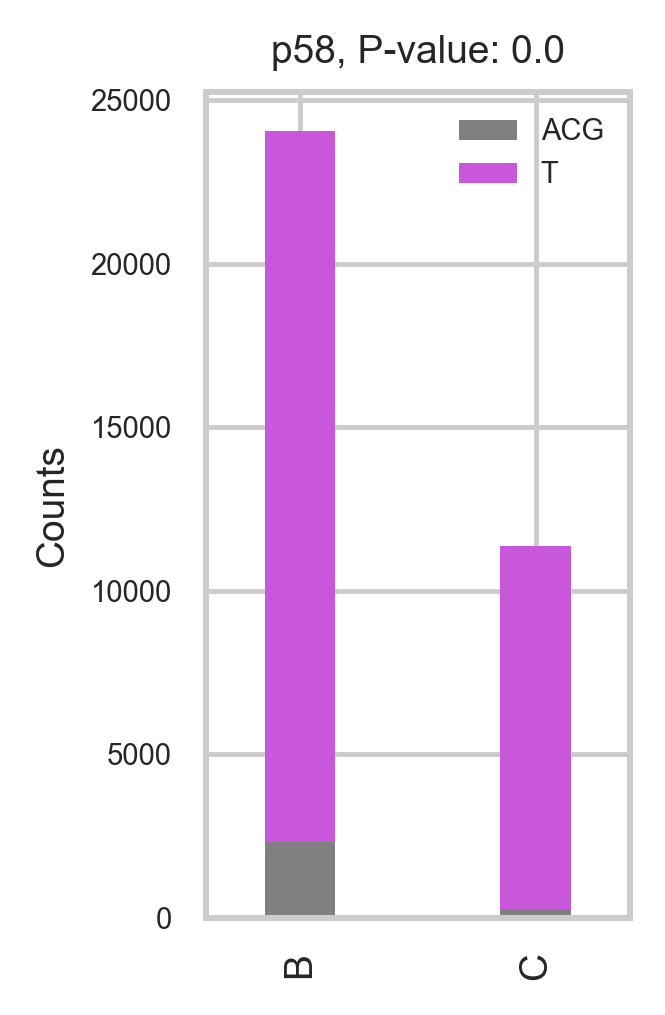

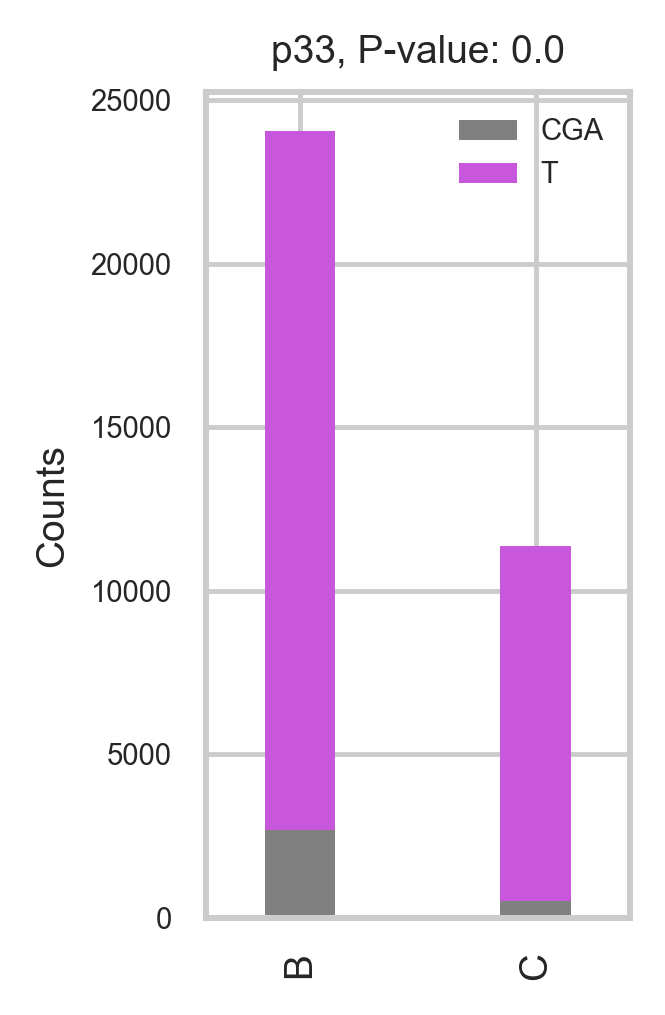

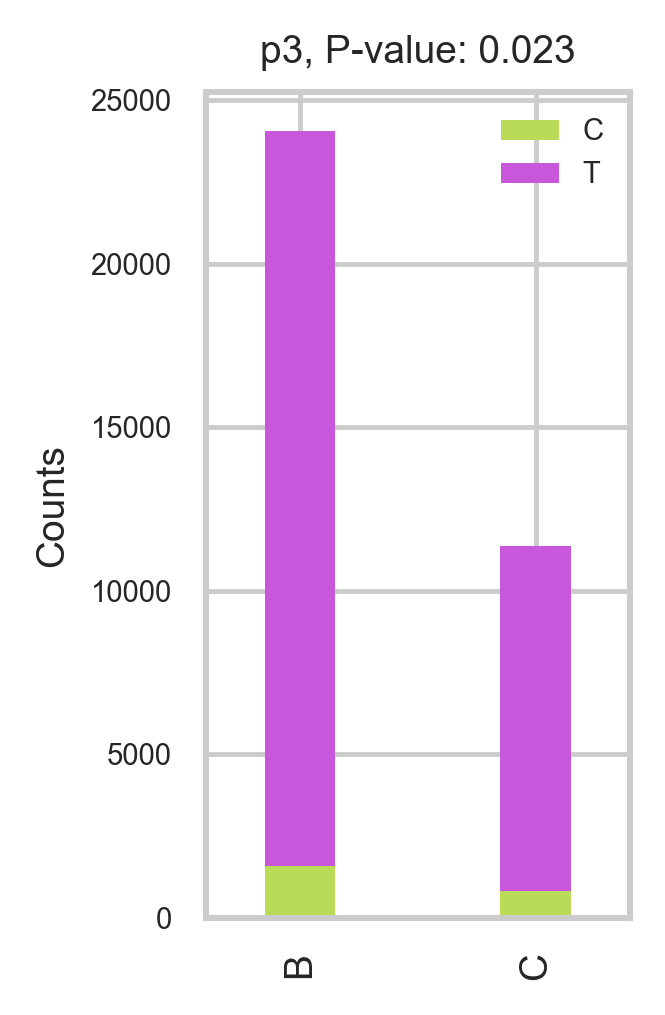

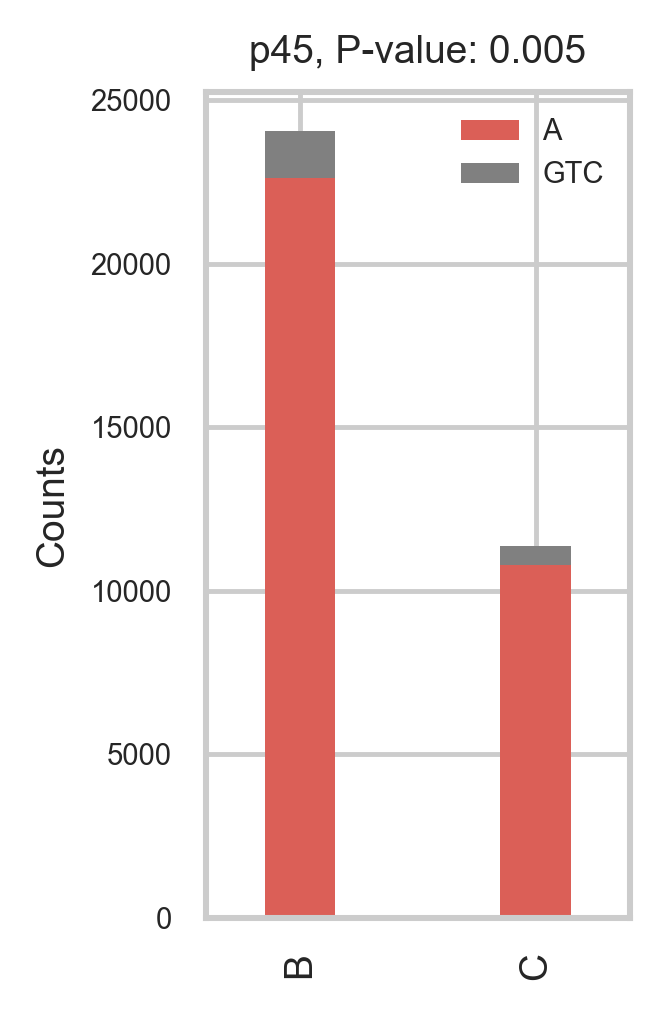

In [23]:
# visualizing top positions 
viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
                 grouped_features=dc, meta_var=mt, model_type=anaType,
                 n_positions=positions, report_dir=report_dir)

In [27]:
import pandas as pd
models = pd.read_csv(report_dir+ '/models_summary.csv', index_col=0)

In [28]:
models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9953,0.9992,0.9924,0.9932,0.9928,0.9893,0.9893,0.076
xgboost,Extreme Gradient Boosting,0.9952,0.9991,0.9922,0.9932,0.9927,0.9891,0.9892,1.271
lr,Logistic Regression,0.9950,0.9992,0.9917,0.9930,0.9924,0.9887,0.9887,0.051
gbc,Gradient Boosting Classifier,0.9951,0.9992,0.9923,0.9926,0.9924,0.9888,0.9888,0.435
et,Extra Trees Classifier,0.9948,0.9987,0.9904,0.9937,0.9920,0.9882,0.9882,0.502
rf,Random Forest Classifier,0.9946,0.9992,0.9906,0.9929,0.9917,0.9878,0.9878,0.211
svm,SVM - Linear Kernel,0.9944,0.0000,0.9906,0.9922,0.9914,0.9872,0.9872,0.029
ada,Ada Boost Classifier,0.9939,0.9991,0.9912,0.9900,0.9906,0.9860,0.9860,0.147
dt,Decision Tree Classifier,0.9889,0.9872,0.9821,0.9836,0.9828,0.9746,0.9746,0.031
ridge,Ridge Classifier,0.9850,0.0000,0.9938,0.9614,0.9773,0.9661,0.9664,0.021


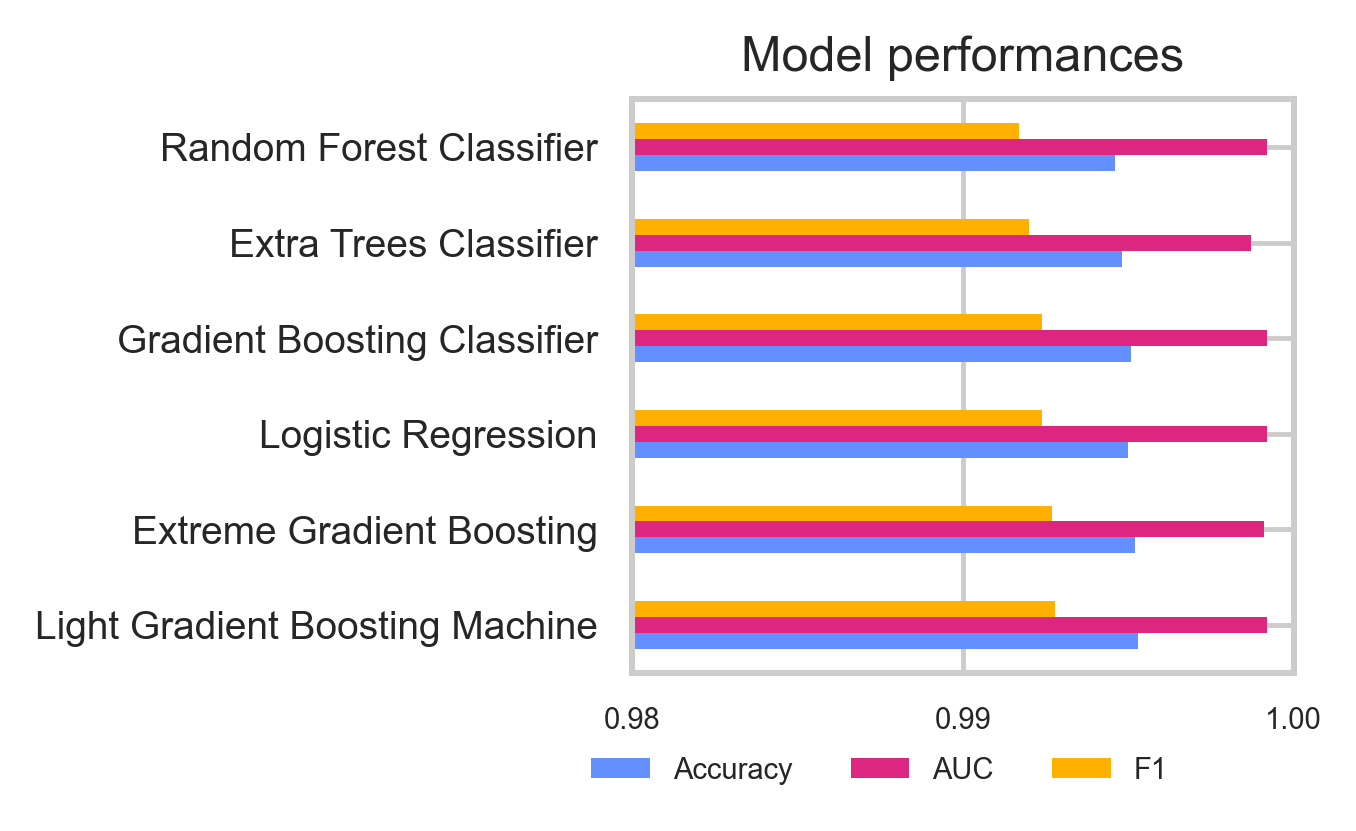

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=350)
fig = models.iloc[:6,].plot(x="Model", y=["Accuracy", "AUC", "F1"],
                           kind="barh",
                           color=['#648FFF', '#DC267F', '#FFB000'],
                           ax=ax,
                           ylim=(0,1))
ax.legend(bbox_to_anchor=(0.85, -.1), fontsize = 6, ncol=3)
ax.set_title('Model performances', fontsize=10)
ax.set_xlabel('')
plt.xticks(fontsize=6)
plt.ylabel('')
plt.xlim(.98,1)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(str(report_dir + '/model_performances.pdf'),
                bbox_inches='tight')